# Setup

In [ ]:
import os
import sys
import re
import yaml
import subprocess
import gzip
import csv

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import plotly

In [ ]:
# prompt: mount my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configs

In [ ]:
annot_map = {
    'Benign':'B/LB',
    'Likely benign':'B/LB',
    'Uncertain significance':'VUS',
    'Pathogenic':'P/LP',
    'Likely pathogenic':'P/LP',
    'Conflicting interpretations of pathogenicity':'VUS'
}


cutoffs = [0, 0.053, 0.23, 0.48, 2.1, 4.3, 18.7, 350, float("inf")]
functional_evidence_codes = [
        "BS3_strong",
        "BS3_moderate",
        "BS3_supporting",
        "Indeterminate",
        "PS3_supporting",
        "PS3_moderate",
        "PS3_strong",
        "PS3_very_strong",
]

color_palette = {
    'B/LB':'darkblue',
    'Benign':'darkblue',
    'Likely benign':'darkblue',
    'BS3':'darkblue',
    'BS3_moderate':'blue',
    'BS3_strong':'darkblue',
    'BS3_supporting':'lightblue',
    'BS3_very_strong':'darkblue',
    'P/LP':'darkred',
    'Pathogenic':'darkred',
    'Likely pathogenic':'darkred',
    'PS3':'darkred',
    'PS3_moderate':'red',
    'PS3_strong':'darkred',
    'PS3_supporting':'pink',
    'PS3_very_strong':'darkred',
    'VUS':'gray',
    'Uncertain significance':'darkgray',
    'Conflicting interpretations of pathogenicity':'lightgray',
    'Indeterminate':'lightgray'
}

## Helpers

In [ ]:
def rounddown(x, sig):
    return np.floor(x / sig) * sig

In [ ]:
def extract_number(s):
    match = re.search(r'[-+]?\d*\.?\d+', str(s))  # Finds integer or decimal numbers
    return int(match.group()) if match else np.nan  # Convert to float or return NaN


In [ ]:
def read_reformat_gnomad(data_path):
    """

    Parameters
    ----------

    Returns
    -------
    """
    clinvar_collapse_dict = {
        'Likely benign':'B/LB',
        'Uncertain significance':'VUS',
        'Benign':'B/LB',
        'Conflicting interpretations of pathogenicity':'VUS',
        'Benign/Likely benign':'B/LB',
        'Pathogenic/Likely pathogenic':'P/LP',
        'Likely pathogenic':'P/LP',
        'Pathogenic':'P/LP'
    }

    # df = pd.read_csv(f'{DATA_PATH}/strativar/gnomAD_v4.1.0_ENSG00000157764_2024_08_13_16_15_20.csv')
    df = pd.read_csv(data_path)
    df['ClinVar Clinical Significance'] = df['ClinVar Germline Classification'].map(clinvar_collapse_dict)
    df['Position_floor'] = [rounddown(x,100) for x in df['Position']]

    vareffect_mapdf = (
        df.filter(['VEP Annotation', 'Protein Consequence',
                   'ClinVar Clinical Significance',
                   'cadd', 'revel_max', 'spliceai_ds_max',
                   'pangolin_largest_ds', 'phylop', 'sift_max', 'polyphen_max'])
        .query('`VEP Annotation`=="missense_variant"')
        .assign(AA = lambda x: [s[-3:] for s in x['Protein Consequence'].values],
                aa_position =  lambda x: [int(re.search('[0-9]{1,3}', s).group(0)) for s in x['Protein Consequence'].values])
        .drop_duplicates()
        .sort_values('aa_position')
        .assign(clinical_annotation = lambda x: x['ClinVar Clinical Significance'].fillna('VUS'))
    )

    return vareffect_mapdf

In [ ]:
def plot_variant_effect_map(df, value_col):
    """

    Parameters
    ----------
    df: - pd.DataFrame - processed assay dataframe from read_and_process_assay(gene, assay)

    Returns
    -------

    """
    ## variant effect map
    # value_col = 'oddspath'
    plotdf = (
        df
        .reset_index()
        .assign(aaalt = lambda x: x['protein_coordinates'].str[-1])
        .filter(['aaalt','aa_position',value_col])
        .pivot(index = 'aaalt',columns = 'aa_position', values = value_col)
        )

    ax=sns.heatmap(plotdf)
    ax.set_title('Variant Effect Map: Functional Assay')

    return ax

In [ ]:
def gnomad_to_variant_effect_map(gnomad_gene_dataset, column):
    """Takes in export from gnomAD and processes the data to create a variant effect map

    Parameters
    ----------
    gnomad_gene_dataset - pd.DataFrame from utils._read_reformat_gnomad(data_path)
    column -


    Returns
    -------

    """
    if column is None:
        column = 'clinvar_num'

    plot_longdf = (
        gnomad_gene_dataset
        .drop_duplicates()
        .sort_values('aa_position')
        .assign(clinical_annotation = lambda x: x['ClinVar Clinical Significance'].fillna('VUS'))
        .drop(columns=['VEP Annotation','ClinVar Clinical Significance'])
        .drop_duplicates()
    )

    plot_widedf = (
        plot_longdf
        .assign(clinvar_num = lambda x: x['clinvar'].map({'VUS':0,'B/LB':1,'P/LP':-1}))
        .filter(['AA','aa_position','clinvar_num','revel_max','cadd'])
        .groupby(['AA','aa_position'])
        .min()
        .reset_index()
        .pivot(index='AA', columns = 'aa_position', values=column)
        .assign(score = lambda x: x[column])
    )

    return sns.heatmap(plot_widedf, cmap='RdBu')

In [ ]:
def gaussian(x, mean, std_dev):
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(
        -0.5 * ((x - mean) / std_dev) ** 2
    )

In [ ]:
def calculate_oddspath_for_predictor(df):
    std_dev_proportion = 0.1
    cutoffs = [0, 0.053, 0.23, 0.48, 2.1, 4.3, 18.7, 350, float("inf")]
    functional_evidence_codes = [
        "BS3_strong",
        "BS3_moderate",
        "BS3_supporting",
        "Indeterminate",
        "PS3_supporting",
        "PS3_moderate",
        "PS3_strong",
        "PS3_very_strong",
    ]


    assays = df["assay"].unique()

    assay_dfs = []
    for assay in assays:
        assay_df = df[df["assay"] == assay]
        pathogenic_df = assay_df[assay_df["clinical_annotation"] == "P/LP"]
        pathogenic_scores = np.array(pathogenic_df["score"].values)
        num_pathogenic_total = len(pathogenic_scores)
        benign_df = assay_df[assay_df["clinical_annotation"] == "B/LB"]
        benign_scores = np.array(benign_df["score"].values)
        num_benign_total = len(benign_scores)
        num_reference_total = num_pathogenic_total + num_benign_total
        all_reference_scores = np.concatenate((pathogenic_scores, benign_scores))
        all_scores = np.sort(assay_df["score"].values)

        if num_benign_total == 0 or num_pathogenic_total == 0:
            likelihood_ratios = np.ones_like(all_scores)
        else:
            std_dev = (max(all_scores) - min(all_scores)) * std_dev_proportion
            likelihood_ratios = []
            for score in all_scores:
                window_pathogenic_gaussian_values = gaussian(
                    pathogenic_scores, score, std_dev
                ).sum()
                window_benign_gaussian_values = gaussian(
                    benign_scores, score, std_dev
                ).sum()
                likelihood_ratio = (
                    window_pathogenic_gaussian_values / num_pathogenic_total
                ) / (window_benign_gaussian_values / num_benign_total)
                likelihood_ratios.append(likelihood_ratio)
            likelihood_ratios = np.array(likelihood_ratios)
            mask = np.isnan(likelihood_ratios)
            likelihood_ratios[mask] = np.interp(
                np.flatnonzero(mask), np.flatnonzero(~mask), likelihood_ratios[~mask]
            )
        likelihood_ratio_dict = dict(zip(all_scores, likelihood_ratios))
        assay_df["oddspath"] = assay_df["score"].map(likelihood_ratio_dict)
        assay_dfs.append(assay_df)
    oddspath_df = pd.concat(assay_dfs)

    oddspath_df["functional_evidence_code"] = pd.cut(
        oddspath_df["oddspath"], bins=cutoffs, labels=functional_evidence_codes
    ).astype(object)

    return oddspath_df

## Set Paths

In [ ]:
project_dir='/content/drive/MyDrive/consulting/inozyme/enpp1'
data_dir=f'{project_dir}/data'
results_dir=f'{project_dir}/results/ENPP1'

## Metadata

In [ ]:
gene="ENPP1"
geneid="ENSG00000197594"
unitprotid="P22413"
transcriptid="NM_006208.3"
chrom="6"
start="131808016"
end="131895155"
icd10=""
phenotype='calciphylaxis'

## input paths
wes_plink="/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, PLINK format - final release/"
plink_file_set=f'{wes_plink}/ukb23158_c{chrom}_b0_v1'
path_to_500kwes_helper_files=f"{wes_plink}/helper_files/"
mavidence_scoresets=''

In [ ]:
os.listdir(data_dir)

['gnomAD_v4.1.0_ENSG00000197594_2025_02_12_08_04_48.csv']

In [ ]:
os.listdir(results_dir)

['ENPP1_alphamissense_calibration_scores.png',
 'ENPP1_alphamissense_calibration_scores.csv',
 'ENPP1_dann_calibration_scores.png',
 'ENPP1_cadd_exome_calibration_scores.csv',
 'ENPP1_clinpred_calibration_scores.csv',
 'ENPP1_chasmplus_calibration_scores.png',
 'ENPP1_chasmplus_calibration_scores.csv',
 'ENPP1_ccr_calibration_scores.png',
 'ENPP1_clinpred_calibration_scores.png',
 'ENPP1_cadd_exome_calibration_scores.png',
 'ENPP1_ccr_calibration_scores.csv',
 'ENPP1_genocanyon_calibration_scores.png',
 'ENPP1_funseq2_calibration_scores.png',
 'ENPP1_dann_calibration_scores.csv',
 'ENPP1_fathmm_calibration_scores.png',
 'ENPP1_esm1b_calibration_scores.csv',
 'ENPP1_esm1b_calibration_scores.png',
 'ENPP1_fathmm_calibration_scores.csv',
 'ENPP1_funseq2_calibration_scores.csv',
 'ENPP1_metasvm_calibration_scores.csv',
 'ENPP1_mistic_calibration_scores.csv',
 'ENPP1_lrt_calibration_scores.csv',
 'ENPP1_lrt_calibration_scores.png',
 'ENPP1_genocanyon_calibration_scores.csv',
 'ENPP1_metasvm

In [ ]:
vep_list = [s.replace('ENPP1_','').replace('_calibration_scores.csv','') for s in os.listdir(results_dir) if 'csv' in s]
vep_list

['alphamissense',
 'cadd_exome',
 'clinpred',
 'chasmplus',
 'ccr',
 'dann',
 'esm1b',
 'fathmm',
 'funseq2',
 'metasvm',
 'mistic',
 'lrt',
 'genocanyon',
 'metalr',
 'mutpred1',
 'sift',
 'siphy',
 'revel']

# gnomAD Section

In [ ]:
gnomad_df = read_reformat_gnomad(data_path=f'{data_dir}/gnomAD_v4.1.0_ENSG00000197594_2025_02_12_08_04_48.csv')
gnomad_df.head()

,VEP Annotation,Protein Consequence,ClinVar Clinical Significance,cadd,revel_max,spliceai_ds_max,pangolin_largest_ds,phylop,sift_max,polyphen_max,AA,aa_position,clinical_annotation
37,missense_variant,p.Arg3His,NaN,22.6,NaN,0.0,0.00,4.740,0.02,0.353,His,3,VUS
39,missense_variant,p.Asp4Asn,VUS,23.0,NaN,0.0,0.00,7.260,0.00,0.188,Asn,4,VUS
41,missense_variant,p.Asp4Glu,NaN,21.5,NaN,0.0,0.00,-0.115,0.00,0.354,Glu,4,VUS
43,missense_variant,p.Gly5Cys,NaN,24.6,NaN,0.0,-0.01,2.510,0.00,0.774,Cys,5,VUS
45,missense_variant,p.Cys6Arg,NaN,20.1,NaN,0.0,0.00,-1.820,0.10,0.445,Arg,6,VUS


In [ ]:
gnomad_df['clinical_annotation'].value_counts()

,count
clinical_annotation,
VUS,1048
P/LP,12
B/LB,11


In [ ]:
score_col='cadd'
gnomad_df = (
    gnomad_df
    .assign(score = lambda x: x[score_col],
            assay = score_col)
)
gnomad_df = calculate_oddspath_for_predictor(gnomad_df)

In [ ]:
## SNP ClinVar annotation count in gnomAD
pd.DataFrame(gnomad_df['functional_evidence_code'].value_counts())

,count
functional_evidence_code,
PS3_moderate,280
PS3_supporting,241
BS3_strong,215
Indeterminate,136
PS3_strong,85
BS3_moderate,75
BS3_supporting,35
PS3_very_strong,4


In [ ]:
pd.crosstab(gnomad_df['functional_evidence_code'],gnomad_df['clinical_annotation'])

clinical_annotation,B/LB,P/LP,VUS
functional_evidence_code,,,
BS3_moderate,1,0,74
BS3_strong,7,0,208
BS3_supporting,1,0,34
Indeterminate,1,0,135
PS3_moderate,0,7,273
PS3_strong,0,1,84
PS3_supporting,1,3,237
PS3_very_strong,0,1,3


In [ ]:
gnomad_df.query('aa_position==179')

,VEP Annotation,Protein Consequence,ClinVar Clinical Significance,cadd,revel_max,spliceai_ds_max,pangolin_largest_ds,phylop,sift_max,polyphen_max,AA,aa_position,clinical_annotation,score,assay,oddspath,functional_evidence_code
906,missense_variant,p.Asn179Asp,NaN,22.8,NaN,0.01,0.01,6.31,0.24,0.405,Asp,179,VUS,22.8,cadd,2.332450,PS3_supporting
907,missense_variant,p.Asn179Ser,NaN,26.0,NaN,0.11,-0.19,4.70,0.01,0.963,Ser,179,VUS,26.0,cadd,7.030103,PS3_moderate
908,missense_variant,p.Asn179Thr,NaN,27.2,NaN,0.10,-0.14,4.70,0.00,0.988,Thr,179,VUS,27.2,cadd,10.586365,PS3_moderate


In [ ]:
gnomad_df.query('aa_position==451')

,VEP Annotation,Protein Consequence,ClinVar Clinical Significance,cadd,revel_max,spliceai_ds_max,pangolin_largest_ds,phylop,sift_max,polyphen_max,AA,aa_position,clinical_annotation,score,assay,oddspath,functional_evidence_code
2136,missense_variant,p.Tyr451Cys,NaN,26.6,NaN,0.0,-0.01,2.28,0.03,0.932,Cys,451,VUS,26.6,cadd,8.616695,PS3_moderate


## Visualize gnomAD

Text(0.5, 1.0, 'Variants present in gnomAD (ClinVar)')

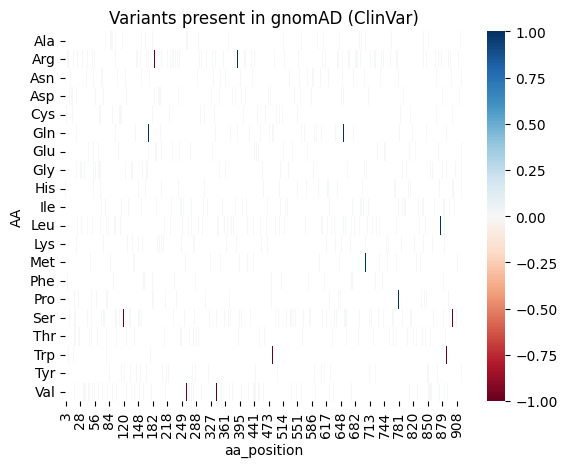

In [ ]:
gnomad_to_variant_effect_map(gnomad_gene_dataset=gnomad_df, column=None)
plt.title('Variants present in gnomAD (ClinVar)')

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Text(0.5, 1.0, 'Variants present in gnomAD (REVEL)')

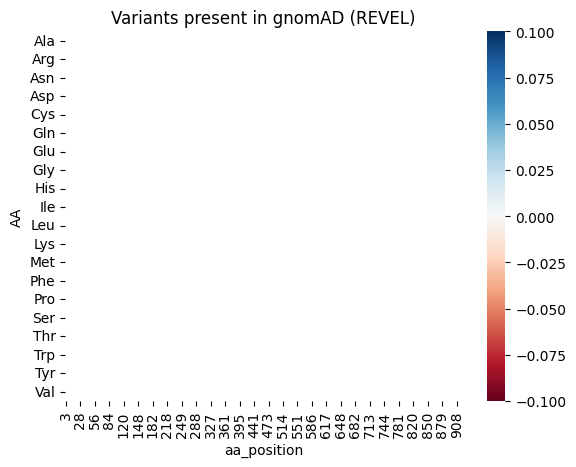

In [ ]:
gnomad_to_variant_effect_map(gnomad_gene_dataset=gnomad_df, column='revel_max')
plt.title('Variants present in gnomAD (REVEL)')

Text(0.5, 1.0, 'Variants present in gnomAD (CADD)')

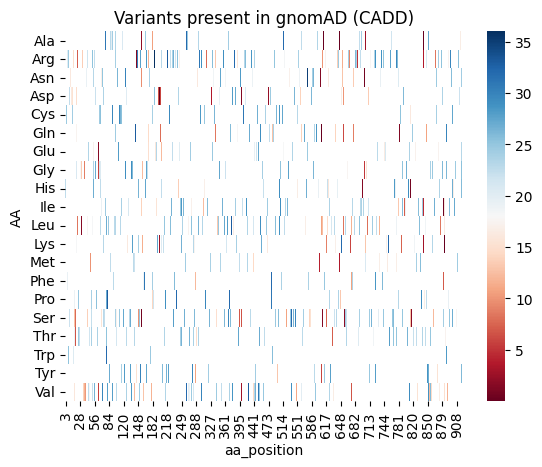

In [ ]:
gnomad_to_variant_effect_map(gnomad_gene_dataset=gnomad_df, column='cadd')
plt.title('Variants present in gnomAD (CADD)')

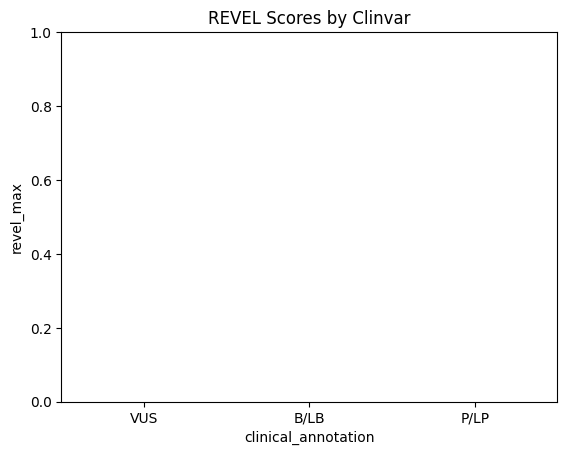

In [ ]:
# Create the violin plot
ax=sns.violinplot(x='clinical_annotation', y='revel_max', data=gnomad_df, inner=None, color="0.8")

# Overlay scatter plot with jitter
sns.stripplot(x='clinical_annotation', y='revel_max', hue='clinical_annotation', palette='Dark2', data=gnomad_df, jitter=True, ax=ax)
plt.title('REVEL Scores by Clinvar')
plt.savefig('ENPP1_violin_revel_by_clinvar.png')

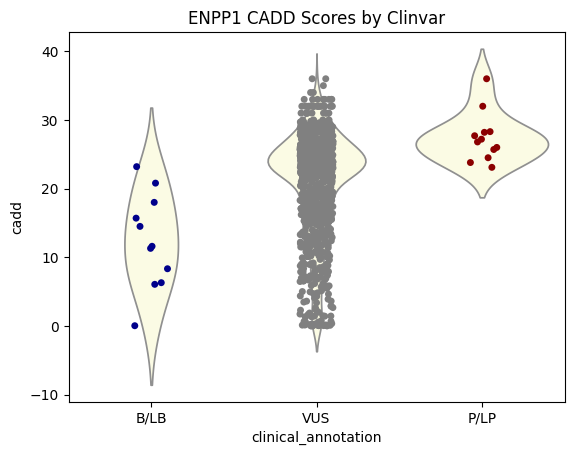

In [ ]:
# Create the violin plot
ax=sns.violinplot(x='clinical_annotation', y='cadd', data=gnomad_df, inner=None, color="lightyellow", order=['B/LB','VUS','P/LP'])

# Overlay scatter plot with jitter
sns.stripplot(x='clinical_annotation', y='cadd', hue='clinical_annotation', palette=color_palette, data=gnomad_df, jitter=True, ax=ax)
plt.title('ENPP1 CADD Scores by Clinvar')
plt.savefig('ENPP1_violin_cadd_by_clinvar.png')

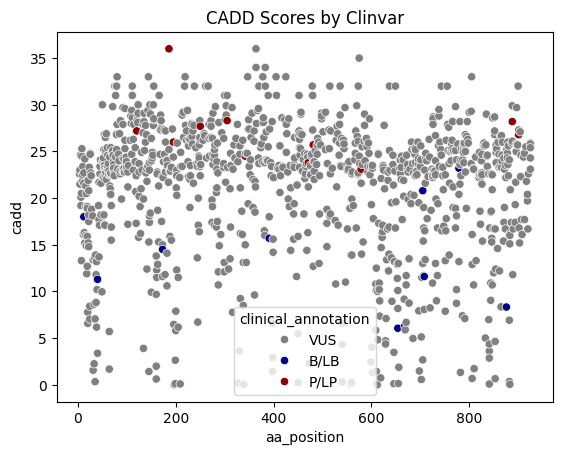

In [ ]:
# Overlay scatter plot with jitter
sns.scatterplot(x='aa_position', y='cadd', hue='clinical_annotation', palette=color_palette, data=gnomad_df)
plt.title('CADD Scores by Clinvar')
plt.savefig('ENPP1_violin_cadd_by_clinvar.png')

## KDE Plot of Reference Sets

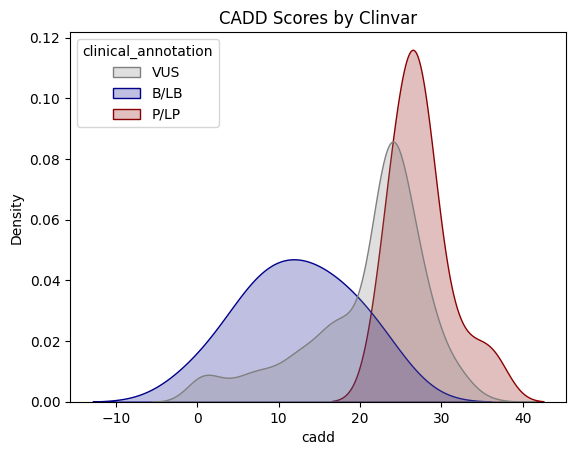

In [ ]:
sns.kdeplot(x='cadd',hue = 'clinical_annotation', data=gnomad_df, fill=True, palette=color_palette, common_norm=False)
plt.title('CADD Scores by Clinvar')
plt.savefig('ENPP1_kde_cadd_by_clinvar.png')

## Draw Biologically Informed Cutoff

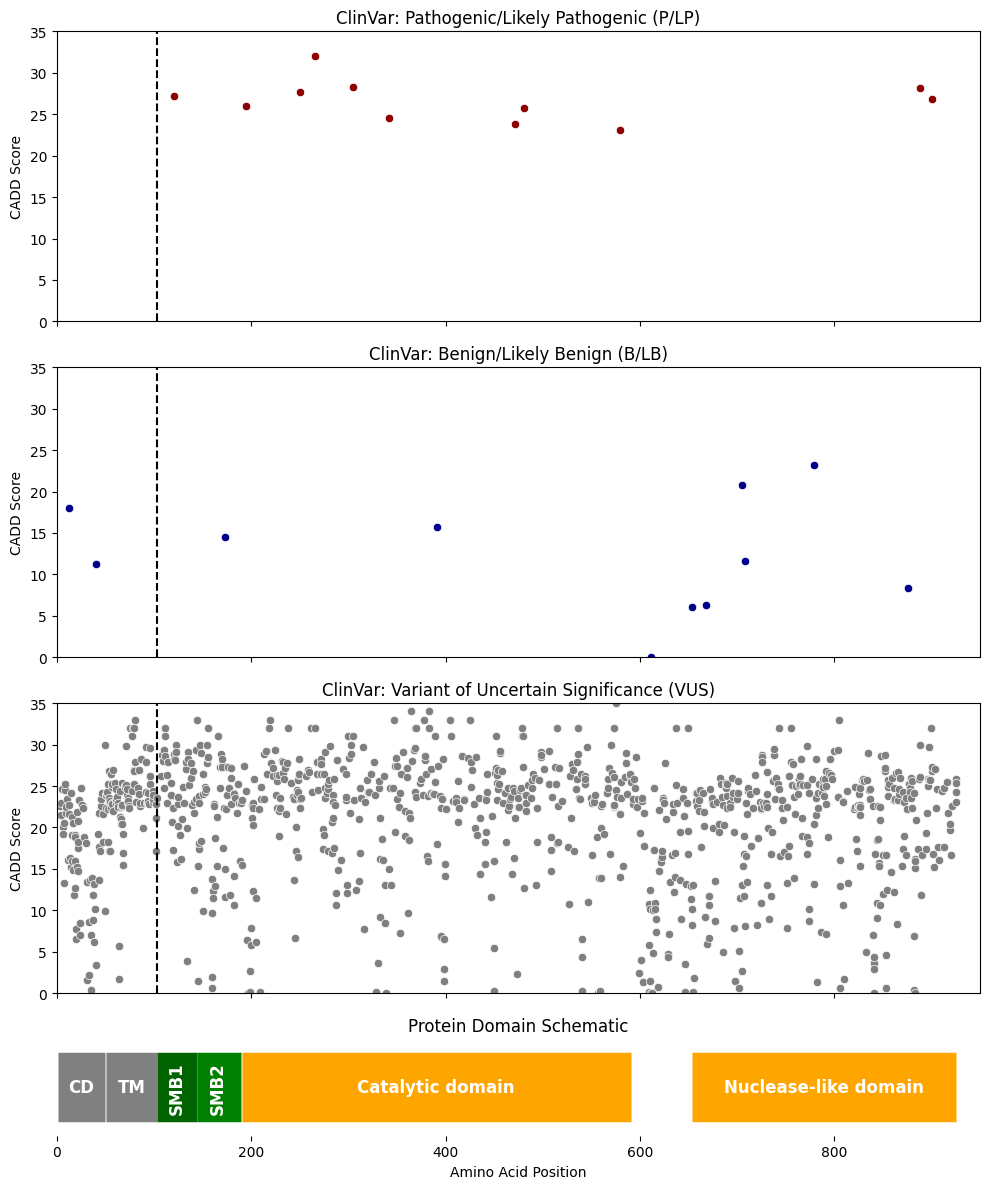

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample filtering
p_lp_df = gnomad_df[gnomad_df['clinical_annotation'] == 'P/LP']
b_lb_df = gnomad_df[gnomad_df['clinical_annotation'] == 'B/LB']
vus_df = gnomad_df[gnomad_df['clinical_annotation'] == 'VUS']

# Set up the figure and axes
fig, axes = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 3, 1]}, figsize=(10, 12))

# Plot top panel (P/LP)
sns.scatterplot(data=p_lp_df, x='aa_position', y='cadd', ax=axes[0], color=color_palette['P/LP'])
axes[0].set_ylim(0,35)
axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].set_title('ClinVar: Pathogenic/Likely Pathogenic (P/LP)')
axes[0].set_ylabel('CADD Score')

# Plot second panel (B/LB)
sns.scatterplot(data=b_lb_df, x='aa_position', y='cadd', ax=axes[1], color=color_palette['B/LB'])
axes[1].set_ylim(0,35)
axes[1].axvline(x=103, linestyle='--', color='black')
axes[1].set_title('ClinVar: Benign/Likely Benign (B/LB)')
axes[1].set_ylabel('CADD Score')

# Plot third panel (VUS)
sns.scatterplot(data=vus_df, x='aa_position', y='cadd', ax=axes[2], color=color_palette['VUS'])
axes[2].set_ylim(0,35)
axes[2].axvline(x=103, linestyle='--', color='black')
axes[2].set_title('ClinVar: Variant of Uncertain Significance (VUS)')
axes[2].set_ylabel('CADD Score')

# Box schematic panel
axes[3].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[3].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[3].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[3].hlines(1, 144, 189, colors='green', linewidth=50)
axes[3].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[3].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[3].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[3].set_xlim(0, 950)
axes[3].set_yticks([])
axes[3].set_xlabel('Amino Acid Position')
axes[3].set_title('Protein Domain Schematic')
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
axes[3].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_aapos_clinvar.png')
plt.show()

## Add Cutoff for CADD Scoring

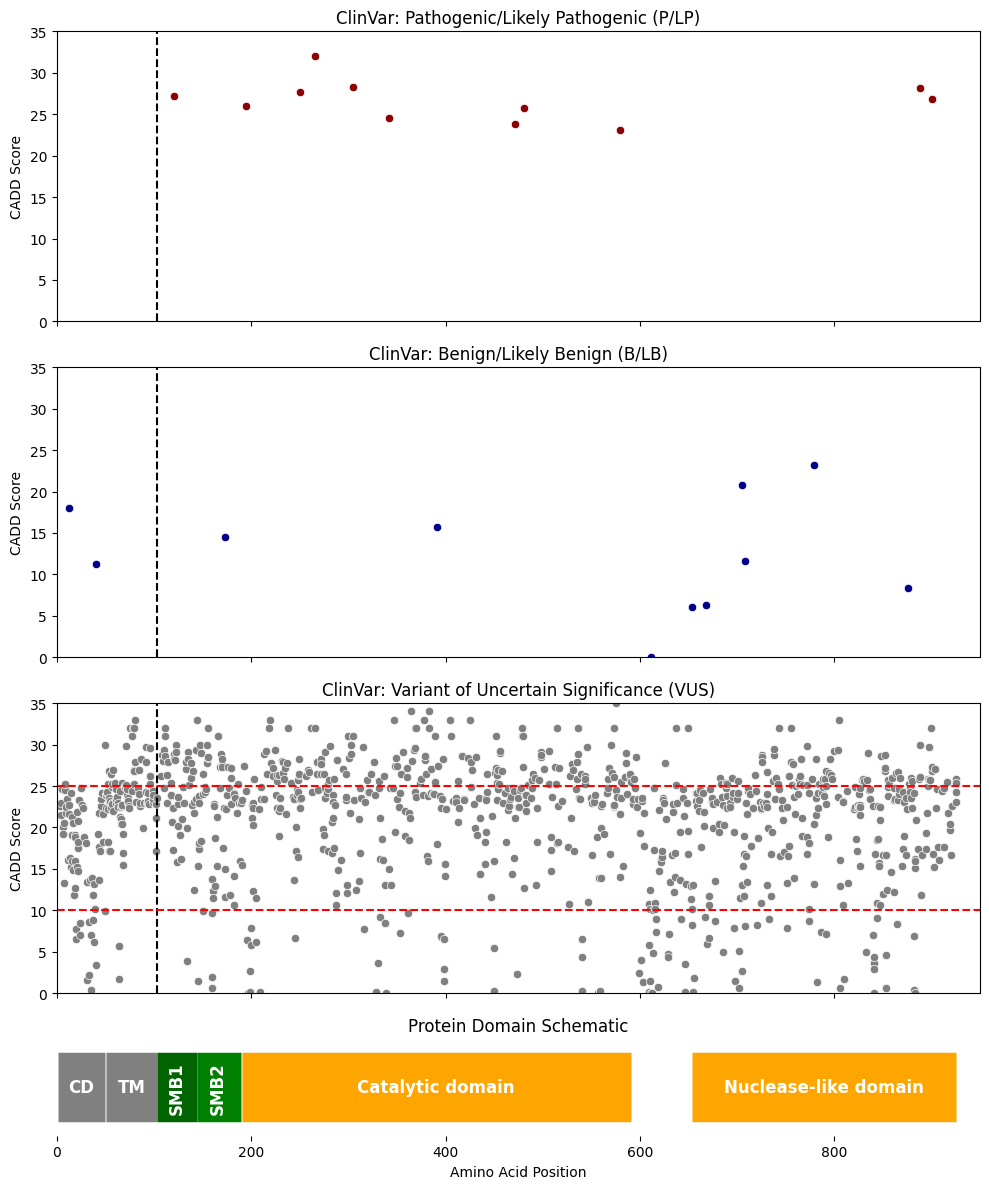

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample filtering
p_lp_df = gnomad_df[gnomad_df['clinical_annotation'] == 'P/LP']
b_lb_df = gnomad_df[gnomad_df['clinical_annotation'] == 'B/LB']
vus_df = gnomad_df[gnomad_df['clinical_annotation'] == 'VUS']

# Set up the figure and axes
fig, axes = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 3, 1]}, figsize=(10, 12))

# Plot top panel (P/LP)
sns.scatterplot(data=p_lp_df, x='aa_position', y='cadd', ax=axes[0], color=color_palette['P/LP'])
axes[0].set_ylim(0,35)
axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].set_title('ClinVar: Pathogenic/Likely Pathogenic (P/LP)')
axes[0].set_ylabel('CADD Score')

# Plot second panel (B/LB)
sns.scatterplot(data=b_lb_df, x='aa_position', y='cadd', ax=axes[1], color=color_palette['B/LB'])
axes[1].set_ylim(0,35)
axes[1].axvline(x=103, linestyle='--', color='black')
axes[1].set_title('ClinVar: Benign/Likely Benign (B/LB)')
axes[1].set_ylabel('CADD Score')

# Plot third panel (VUS)
sns.scatterplot(data=vus_df, x='aa_position', y='cadd', ax=axes[2], color=color_palette['VUS'])
axes[2].set_ylim(0,35)
axes[2].axvline(x=103, linestyle='--', color='black')
axes[2].axhline(y=10, linestyle='--', color='red') ## putative CADD cutoffs
axes[2].axhline(y=25, linestyle='--', color='red') ## putative CADD cutoffs
axes[2].set_title('ClinVar: Variant of Uncertain Significance (VUS)')
axes[2].set_ylabel('CADD Score')

# Box schematic panel
axes[3].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[3].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[3].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[3].hlines(1, 144, 189, colors='green', linewidth=50)
axes[3].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[3].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[3].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[3].set_xlim(0, 950)
axes[3].set_yticks([])
axes[3].set_xlabel('Amino Acid Position')
axes[3].set_title('Protein Domain Schematic')
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
axes[3].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_aapos_clinvar.png')
plt.show()

## All Variants No Cutoffs

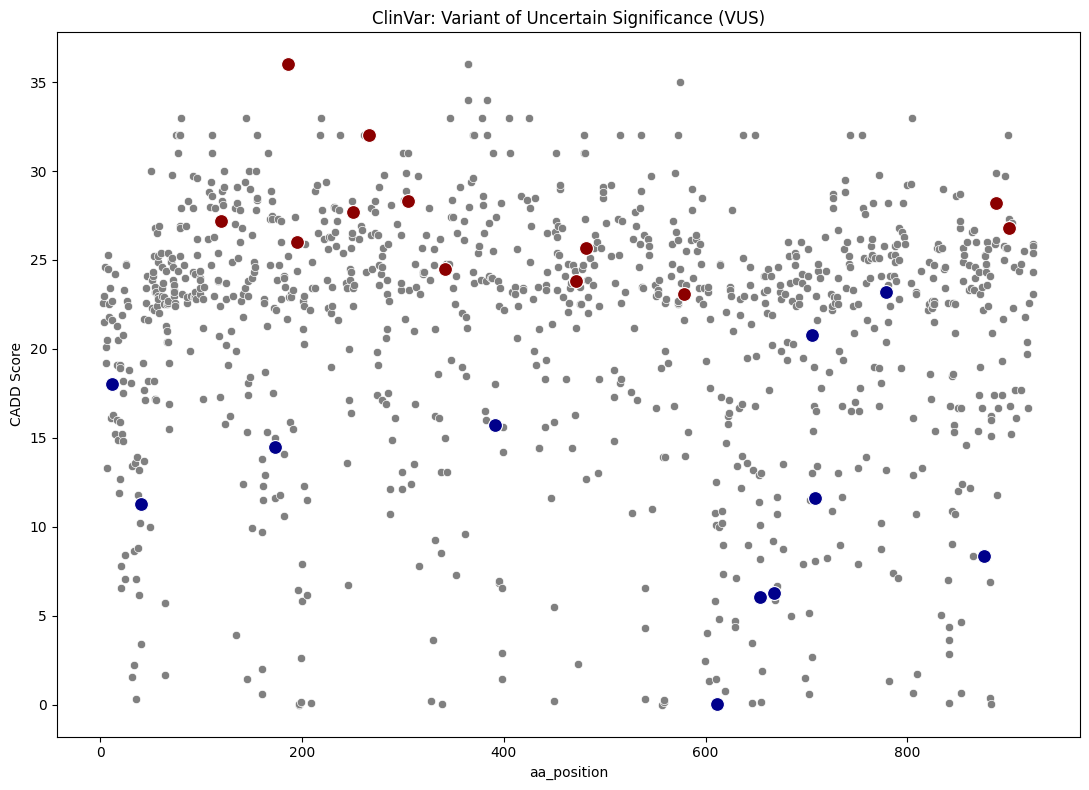

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
p_lp_df = gnomad_df[gnomad_df['clinical_annotation'] == 'P/LP']
b_lb_df = gnomad_df[gnomad_df['clinical_annotation'] == 'B/LB']
rest_df = gnomad_df[gnomad_df['clinical_annotation'] != 'P/LP']


sns.scatterplot(data=rest_df, x='aa_position', y='cadd', ax=ax, color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position', y='cadd', ax=ax, color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='cadd', ax=ax, color=color_palette['B/LB'], s=100)
# axes[0].axvline(x=103, linestyle='--', color='black')
# axes[0].axhline(y=10, linestyle='--', color='red') ## putative CADD cutoffs
# axes[0].axhline(y=25, linestyle='--', color='red') ## putative CADD cutoffs
ax.set_title('ClinVar: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('CADD Score')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

## All Variants Highlight P/LP

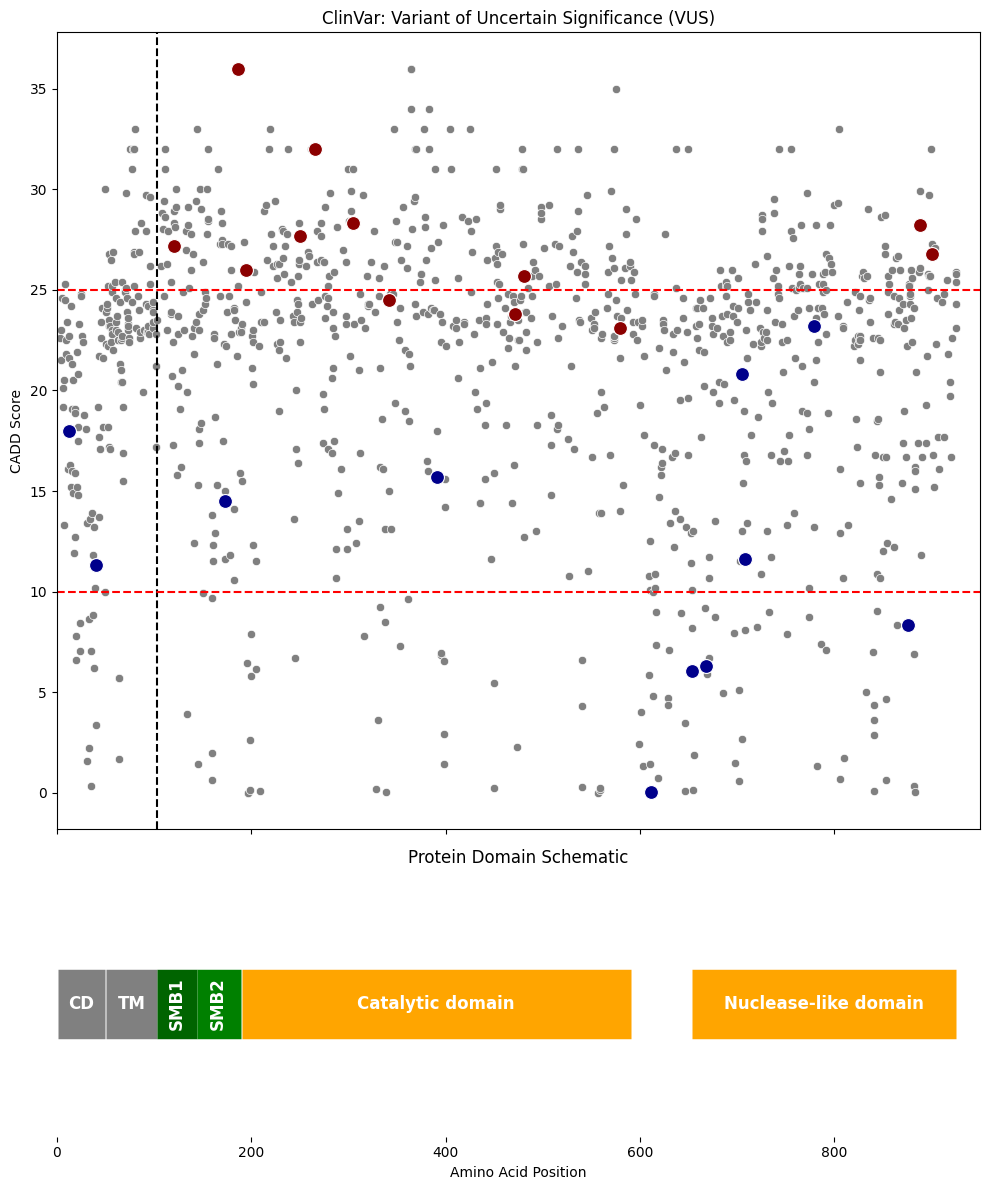

In [ ]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 12))

# Plot Variant Panel
# Sample filtering
p_lp_df = gnomad_df[gnomad_df['clinical_annotation'] == 'P/LP']
b_lb_df = gnomad_df[gnomad_df['clinical_annotation'] == 'B/LB']
rest_df = gnomad_df[gnomad_df['clinical_annotation'] != 'P/LP']


sns.scatterplot(data=rest_df, x='aa_position', y='cadd', ax=axes[0], color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position', y='cadd', ax=axes[0], color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='cadd', ax=axes[0], color=color_palette['B/LB'], s=100)
axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].axhline(y=10, linestyle='--', color='red') ## putative CADD cutoffs
axes[0].axhline(y=25, linestyle='--', color='red') ## putative CADD cutoffs
axes[0].set_title('ClinVar: Variant of Uncertain Significance (VUS)')
axes[0].set_ylabel('CADD Score')

# Box schematic panel
axes[1].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[1].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[1].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[1].hlines(1, 144, 189, colors='green', linewidth=50)
axes[1].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[1].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[1].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[1].set_xlim(0, 950)
axes[1].set_yticks([])
axes[1].set_xlabel('Amino Acid Position')
axes[1].set_title('Protein Domain Schematic')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

## All VUS Highlight Case Study Variants

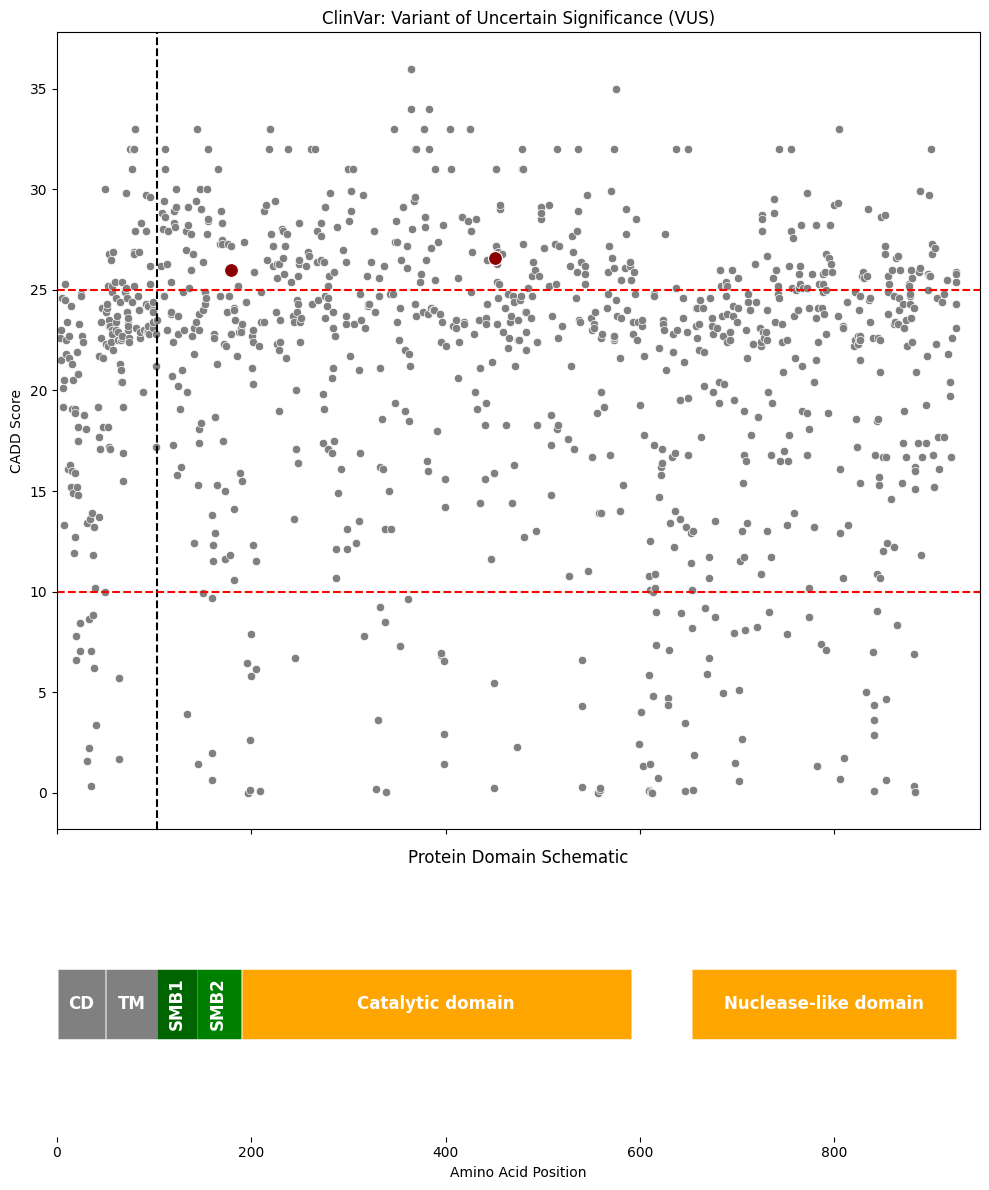

In [ ]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 12))

# Plot third panel (VUS)
var_list=['p.Asn179Ser','p.Tyr451Cys']
vus_gray = vus_df[~vus_df['Protein Consequence'].isin(var_list)]
vus_highlight = vus_df[vus_df['Protein Consequence'].isin(var_list)]

sns.scatterplot(data=vus_gray, x='aa_position', y='cadd', ax=axes[0], color=color_palette['VUS'])
sns.scatterplot(data=vus_highlight, x='aa_position', y='cadd', ax=axes[0], color=color_palette['P/LP'], s=100)
axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].axhline(y=10, linestyle='--', color='red') ## putative CADD cutoffs
axes[0].axhline(y=25, linestyle='--', color='red') ## putative CADD cutoffs
axes[0].set_title('ClinVar: Variant of Uncertain Significance (VUS)')
axes[0].set_ylabel('CADD Score')

# Box schematic panel
axes[1].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[1].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[1].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[1].hlines(1, 144, 189, colors='green', linewidth=50)
axes[1].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[1].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[1].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[1].set_xlim(0, 950)
axes[1].set_yticks([])
axes[1].set_xlabel('Amino Acid Position')
axes[1].set_title('Protein Domain Schematic')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_case_variants.png')
plt.show()

# VEP Scores Data Section

## Skim All **VEPs**

In [ ]:
## Variants from https://pmc.ncbi.nlm.nih.gov/articles/PMC9177665/
var_list = ['N179S','p.Asn179Ser','Y451C','p.Tyr451Cys']

In [ ]:
vep='cadd_exome'
score_df = pd.read_csv(f'{results_dir}/ENPP1_{vep}_calibration_scores.csv')

In [ ]:
score_df

,Unnamed: 0.1,Unnamed: 0,UID,Chrom,Position,Ref Base,Alt Base,Variant Note,Coding,Gene,...,Alternate allele,assay,clinical_annotation,score,oddspath,functional_evidence_code,auroc,num_pathogenic,num_benign,total_variants
0,0,0,1,chr6,131890410,G,T,NaN,Yes,ENPP1,...,T,cadd_exome,Pathogenic,9.428650,2.082307e+09,PS3_very_strong,0.999795,33,148,181
1,1,1,2,chr6,131884939,C,T,NaN,Yes,ENPP1,...,T,cadd_exome,Uncertain significance,3.296722,9.169346e+00,PS3_moderate,0.999795,33,148,181
2,2,2,3,chr6,131877005,G,C,NaN,Yes,ENPP1,...,C,cadd_exome,Pathogenic,2.820196,3.033861e+00,PS3_supporting,0.999795,33,148,181
3,3,3,4,chr6,131851228,A,C,NaN,Yes,ENPP1,...,C,cadd_exome,Benign,1.321265,8.130744e-02,BS3_moderate,0.999795,33,148,181
4,4,4,5,chr6,131891554,A,G,NaN,NaN,ENPP1,...,G,cadd_exome,Benign,0.258418,6.102886e-03,BS3_strong,0.999795,33,148,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,468,632,633,chr6,131879896,T,A,NaN,Yes,ENPP1,...,A,cadd_exome,Benign,0.457842,9.942067e-03,BS3_strong,0.999795,33,148,181
469,469,633,634,chr6,131890360,C,T,NaN,Yes,ENPP1,...,T,cadd_exome,Benign,0.686617,1.737351e-02,BS3_strong,0.999795,33,148,181
470,470,634,635,chr6,131890487,G,T,NaN,Yes,ENPP1,...,T,cadd_exome,Uncertain significance,3.274763,8.723758e+00,PS3_moderate,0.999795,33,148,181
471,471,635,636,chr6,131847795,T,C,NaN,Yes,ENPP1,...,C,cadd_exome,Uncertain significance,4.156587,5.655009e+01,PS3_strong,0.999795,33,148,181


In [ ]:
score_df_list = []
for vep in vep_list:
  print(f'Running for {vep}')
  score_df = (
      pd.read_csv(f'{results_dir}/ENPP1_{vep}_calibration_scores.csv')
      .assign(clinical_annotation = lambda x: x['clinical_annotation'].map(annot_map),
              func_code_short = lambda x: [s.split('_')[0] for s in x['functional_evidence_code']],
              log_oddspath = lambda x: np.log(x['oddspath']),
              aa_position = lambda x: [extract_number(s) for s in x['Protein Change']])
      )

  ## save score dataset
  score_df_list.append(score_df)

  ## plot kdeplot
  sns.set(rc={'axes.facecolor':'white'})
  sns.kdeplot(x='score',hue = 'clinical_annotation', data=score_df, fill=True, palette=color_palette, common_norm=False)
  plt.title(f'{vep} Scores by Clinvar')
  plt.savefig(f'ENPP1_kde_{vep}_by_clinvar.png')
  plt.close()


Running for alphamissense
Running for cadd_exome
Running for clinpred
Running for chasmplus
Running for ccr
Running for dann
Running for esm1b
Running for fathmm
Running for funseq2
Running for metasvm
Running for mistic
Running for lrt
Running for genocanyon
Running for metalr
Running for mutpred1
Running for sift
Running for siphy
Running for revel


In [ ]:
pd.concat(score_df_list)['assay'].value_counts()

,count
assay,
funseq2,614
cadd_exome,473
dann,467
sift,321
siphy,266
genocanyon,266
lrt,249
metasvm,238
metalr,238


In [ ]:
pd.concat(score_df_list).query('`Protein Change`=="p.Asn179Ser"').filter(['assay','clinical_annotation','score','oddspath','functional_evidence_code','auroc']).sort_values('functional_evidence_code')

,assay,clinical_annotation,score,oddspath,functional_evidence_code,auroc
45,alphamissense,Uncertain significance,0.116400,0.187235,BS3_moderate,0.952381
45,clinpred,Uncertain significance,0.234000,0.000235,BS3_strong,1.000000
45,chasmplus,Uncertain significance,0.031000,0.653745,Indeterminate,0.964286
45,fathmm,Uncertain significance,0.790000,0.503562,Indeterminate,0.214286
45,metasvm,Uncertain significance,-0.432200,2.022573,Indeterminate,1.000000
45,mistic,Uncertain significance,0.299589,0.647931,Indeterminate,0.942857
45,metalr,Uncertain significance,0.264000,0.608548,Indeterminate,0.995238
45,revel,Uncertain significance,0.382000,1.256183,Indeterminate,1.000000
157,funseq2,Uncertain significance,2.000000,16.718446,PS3_moderate,0.946643
144,cadd_exome,Uncertain significance,3.824500,28.967387,PS3_strong,0.999795


In [ ]:
(
    pd.concat(score_df_list)
    .query('`Protein Change`=="p.Asn179Ser"')
    .assign(func_code_short = lambda x: [s.split('_')[0] for s in x['functional_evidence_code']])
    .groupby('func_code_short')
    .agg({'auroc':'mean','oddspath':'mean','func_code_short':'count'})
    .round(3)
)


,auroc,oddspath,func_code_short
func_code_short,,,
BS3,0.976,0.094,2
Indeterminate,0.853,0.949,6
PS3,0.552,11.433,7


In [ ]:
pd.concat(score_df_list).query('`Protein Change`=="p.Tyr451Cys"').filter(['assay','clinical_annotation','score','oddspath','functional_evidence_code','auroc']).sort_values('functional_evidence_code')

,assay,clinical_annotation,score,oddspath,functional_evidence_code,auroc
68,clinpred,Uncertain significance,0.087000,5.533436e-08,BS3_strong,1.000000
68,alphamissense,Uncertain significance,0.207700,4.582798e-01,BS3_supporting,0.952381
68,chasmplus,Uncertain significance,0.034000,9.138655e-01,Indeterminate,0.964286
234,dann,Uncertain significance,0.663538,5.679874e-01,Indeterminate,0.361780
68,fathmm,Uncertain significance,-0.650000,6.239228e-01,Indeterminate,0.214286
68,metasvm,Uncertain significance,-0.464500,1.487632e+00,Indeterminate,1.000000
68,metalr,Uncertain significance,0.336500,1.635480e+00,Indeterminate,0.995238
78,siphy,Uncertain significance,10.969300,5.600015e-01,Indeterminate,0.943478
68,esm1b,Uncertain significance,-12.266000,9.763301e+00,PS3_moderate,0.019048
308,funseq2,Uncertain significance,2.000000,1.671845e+01,PS3_moderate,0.946643


In [ ]:
(
    pd.concat(score_df_list)
    .query('`Protein Change`=="p.Tyr451Cys"')
    .assign(func_code_short = lambda x: [s.split('_')[0] for s in x['functional_evidence_code']])
    .groupby('func_code_short')
    .agg({'auroc':'mean','oddspath':'mean','func_code_short':'count'})
    .round(3)
)


,auroc,oddspath,func_code_short
func_code_short,,,
BS3,0.976,0.229,2
Indeterminate,0.747,0.965,6
PS3,0.608,10.401,8


## Deep Dive Individual VEPs

In [ ]:
## Clinical-trained predictors
vep='cadd_exome'
# vep='revel'

# ## Population-tuned predictors
# vep='alphamissense'
# vep='metalr'

# ## Population-free predictors
# vep='esm1b'
# vep='sift'
score_df = pd.read_csv(f'{results_dir}/ENPP1_{vep}_calibration_scores.csv')

### Functional Evidence Code Count

<ipython-input-397-d127dfa45e10>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='functional_evidence_code', data=score_df, order=functional_evidence_codes, palette=color_palette)


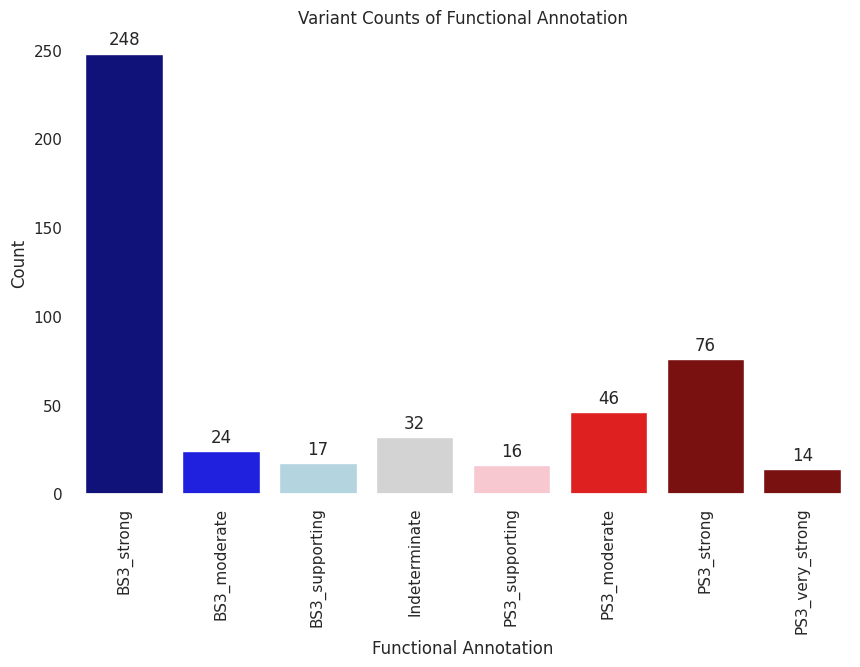

In [ ]:
# Reindex the value counts
# score_df['functional_evidence_code'].value_counts().reindex(custom_order).fillna(0).plot(kind='bar')

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='functional_evidence_code', data=score_df, order=functional_evidence_codes, palette=color_palette)
plt.title('Variant Counts of Functional Annotation')
plt.xlabel('Functional Annotation')
plt.xticks(rotation=90)
plt.ylabel('Count')

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [ ]:
score_df = (
    score_df
    .assign(functional_evidence_code = lambda x: ['Indeterminate' if 'supporting' in s else s for s in x['functional_evidence_code']])
    #.assign(functional_evidence_code = lambda x: ['Indeterminate' if 'moderate' in s else s for s in x['functional_evidence_code']])
    .assign(clinical_annotation = lambda x: x['clinical_annotation'].map(annot_map),
            func_code_short = lambda x: [s.split('_')[0] for s in x['functional_evidence_code']],
            log_oddspath = lambda x: np.log(x['oddspath']),
            aa_position = lambda x: [extract_number(s) for s in x['Protein Change']])
)
pd.crosstab(score_df['clinical_annotation'],score_df['func_code_short'])

func_code_short,BS3,Indeterminate,PS3
clinical_annotation,,,
B/LB,145,3,0
P/LP,0,1,32
VUS,127,61,104


### KDE of VEP Score by Clinical Annotation

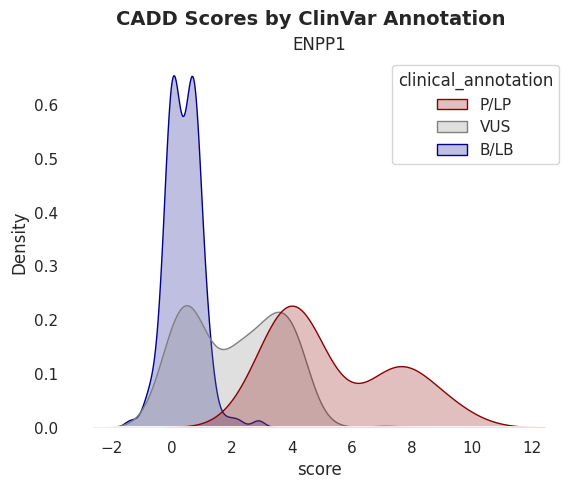

In [ ]:
sns.kdeplot(x='score',hue = 'clinical_annotation', data=score_df, fill=True, palette=color_palette, common_norm=False)
plt.title('ENPP1', fontsize=12)
plt.suptitle('CADD Scores by ClinVar Annotation', fontsize=14,fontweight='bold')
plt.savefig('ENPP1_kde_cadd_by_clinvar.png')

In [ ]:
score_df.groupby('clinical_annotation')['log_oddspath'].agg(['mean','std','count','median']).round(3)

,mean,std,count,median
clinical_annotation,,,,
B/LB,-4.783,1.406,148,-4.780
P/LP,7.513,5.765,33,4.348
VUS,-0.793,3.709,292,-0.561


### VEP Score by Clinical Annotation Violin Plot

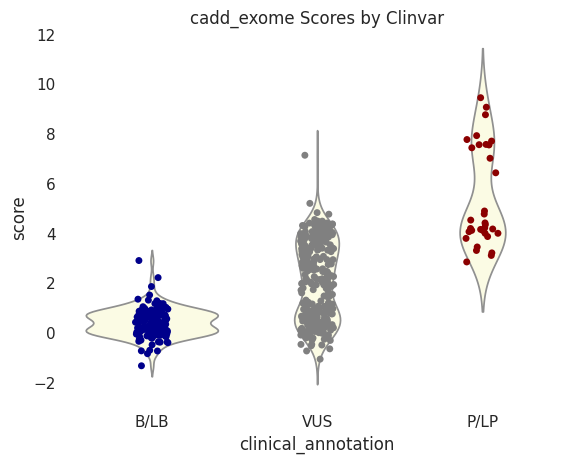

In [ ]:
# Create the violin plot
ax=sns.violinplot(x='clinical_annotation', y='score', data=score_df, inner=None, color="lightyellow", order=['B/LB','VUS','P/LP'])

# Overlay scatter plot with jitter
sns.stripplot(x='clinical_annotation', y='score', hue='clinical_annotation', palette=color_palette, data=score_df, jitter=True, ax=ax)
plt.title(f'{vep} Scores by Clinvar')
plt.savefig(f'ENPP1_violin_cadd_by_clinvar.png')

### Manually Selected Thresholds

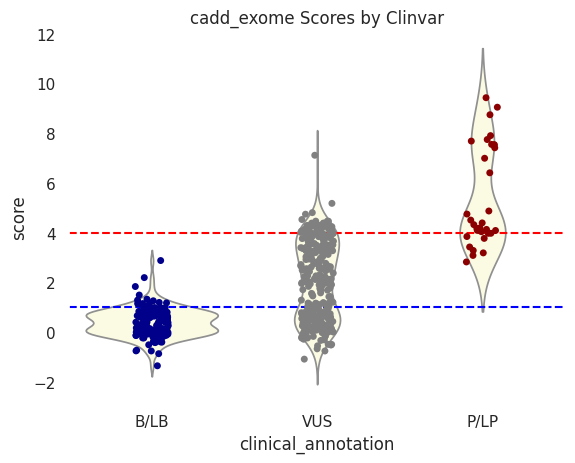

In [ ]:
# Create the violin plot
ax=sns.violinplot(x='clinical_annotation', y='score', data=score_df, inner=None, color="lightyellow", order=['B/LB','VUS','P/LP'])

# Overlay scatter plot with jitter
sns.stripplot(x='clinical_annotation', y='score', hue='clinical_annotation', palette=color_palette, data=score_df, jitter=True, ax=ax)
ax.axhline(y=1, linestyle='--', color='blue')
ax.axhline(y=4, linestyle='--', color='red')
plt.title(f'{vep} Scores by Clinvar')
plt.savefig(f'ENPP1_violin_cadd_by_clinvar.png')

### VEP Score by Functional Evidence Code Violin Plot

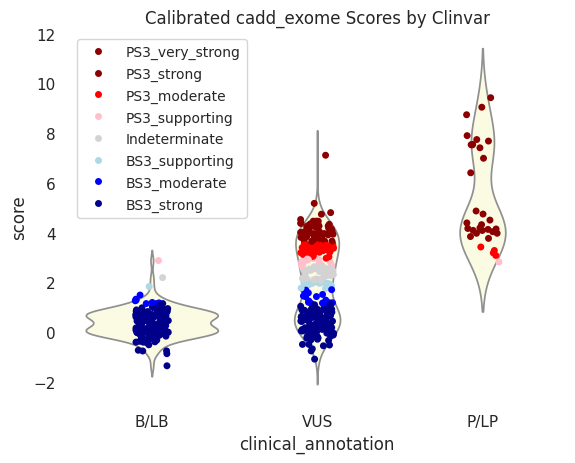

In [ ]:
# Create the violin plot
ax=sns.violinplot(x='clinical_annotation', y='score', data=score_df, inner=None, color="lightyellow", order=['B/LB','VUS','P/LP'])

# Overlay scatter plot with jitter
sns.stripplot(x='clinical_annotation', y='score', hue='functional_evidence_code', hue_order=functional_evidence_codes[::-1], palette=color_palette, data=score_df, jitter=True, ax=ax)

# Get the legend object
legend = ax.get_legend()
legend.set_title([])
plt.setp(legend.get_texts(), fontsize='small') #or 'x-small','medium','large'

plt.title(f'Calibrated {vep} Scores by Clinvar')
plt.savefig(f'ENPP1_violin_cadd_by_clinvar_functional_code.png')

### VEP Log Oddspath by Functional Evidence Code Violin Plot

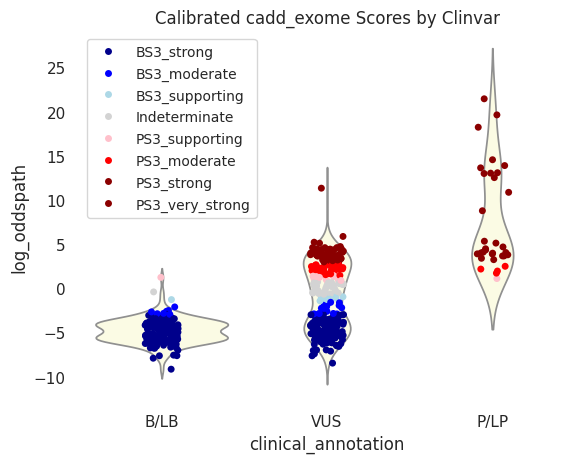

In [ ]:
# Create the violin plot
ax=sns.violinplot(x='clinical_annotation', y='log_oddspath', data=score_df, inner=None, color="lightyellow", order=['B/LB','VUS','P/LP'])

# Overlay scatter plot with jitter
sns.stripplot(x='clinical_annotation', y='log_oddspath', hue='functional_evidence_code', hue_order=functional_evidence_codes, palette=color_palette, data=score_df, jitter=True, ax=ax)

# Get the legend object
legend = ax.get_legend()
legend.set_title([])
plt.setp(legend.get_texts(), fontsize='small') #or 'x-small','medium','large'

plt.title(f'Calibrated {vep} Scores by Clinvar')
plt.savefig(f'ENPP1_violin_cadd_log_oddspath_by_clinvar_functional_code.png')

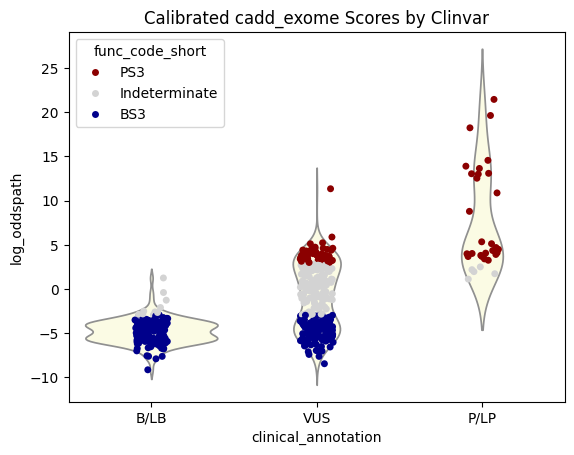

In [ ]:
# Create the violin plot
ax=sns.violinplot(x='clinical_annotation', y='log_oddspath', data=score_df, inner=None, color="lightyellow", order=['B/LB','VUS','P/LP'])

# Overlay scatter plot with jitter
sns.stripplot(x='clinical_annotation', y='log_oddspath', hue='func_code_short', palette=color_palette, data=score_df, jitter=True, ax=ax)
plt.title(f'Calibrated {vep} Scores by Clinvar')
plt.savefig(f'ENPP1_violin_cadd_by_clinvar_functional_code.png')

### Scatterpot by AA Position

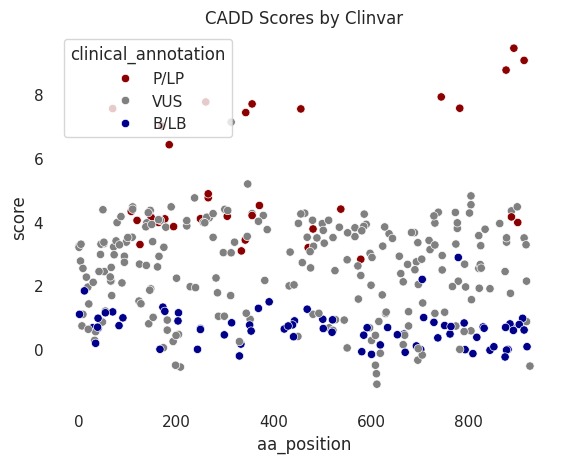

In [ ]:
# Overlay scatter plot with jitter
sns.scatterplot(x='aa_position', y='score', hue='clinical_annotation', palette=color_palette, data=score_df)
plt.title('CADD Scores by Clinvar')
plt.savefig('ENPP1_violin_cadd_by_clinvar.png')

#### Draw Biologically Informed Cutoff

In [ ]:
score_df.groupby('clinical_annotation')['score'].agg(['count','mean','std']).round(3).reindex(['B/LB','VUS','P/LP'])

,count,mean,std
clinical_annotation,,,
B/LB,148,0.390,0.574
VUS,292,2.064,1.569
P/LP,33,5.364,2.005


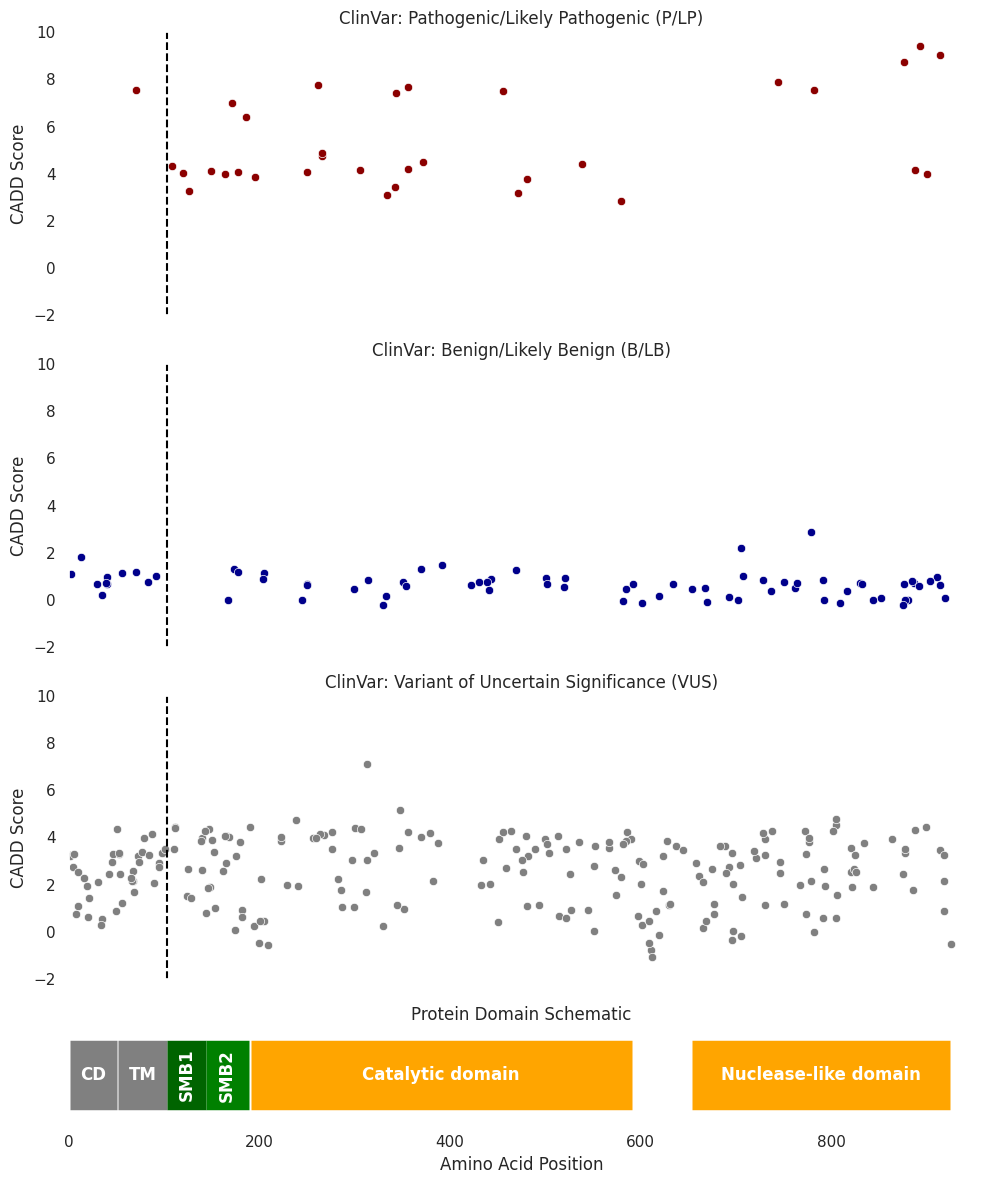

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample filtering
p_lp_df = score_df[score_df['clinical_annotation'] == 'P/LP']
b_lb_df = score_df[score_df['clinical_annotation'] == 'B/LB']
vus_df = score_df[score_df['clinical_annotation'] == 'VUS']

# Set up the figure and axes
fig, axes = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 3, 1]}, figsize=(10, 12))

# Plot top panel (P/LP)
sns.scatterplot(data=p_lp_df, x='aa_position', y='score', ax=axes[0], color=color_palette['P/LP'])
axes[0].set_ylim(-2,10)
axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].set_title('ClinVar: Pathogenic/Likely Pathogenic (P/LP)')
axes[0].set_ylabel('CADD Score')

# Plot second panel (B/LB)
sns.scatterplot(data=b_lb_df, x='aa_position', y='score', ax=axes[1], color=color_palette['B/LB'])
axes[1].set_ylim(-2,10)
axes[1].axvline(x=103, linestyle='--', color='black')
axes[1].set_title('ClinVar: Benign/Likely Benign (B/LB)')
axes[1].set_ylabel('CADD Score')

# Plot third panel (VUS)
sns.scatterplot(data=vus_df, x='aa_position', y='score', ax=axes[2], color=color_palette['VUS'])
axes[2].set_ylim(-2,10)
axes[2].axvline(x=103, linestyle='--', color='black')
axes[2].set_title('ClinVar: Variant of Uncertain Significance (VUS)')
axes[2].set_ylabel('CADD Score')

# Box schematic panel
axes[3].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[3].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[3].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[3].hlines(1, 144, 189, colors='green', linewidth=50)
axes[3].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[3].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[3].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[3].set_xlim(0, 950)
axes[3].set_yticks([])
axes[3].set_xlabel('Amino Acid Position')
axes[3].set_title('Protein Domain Schematic')
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
axes[3].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_aapos_clinvar.png')
plt.show()

#### Add Cutoff For VEP Scoring

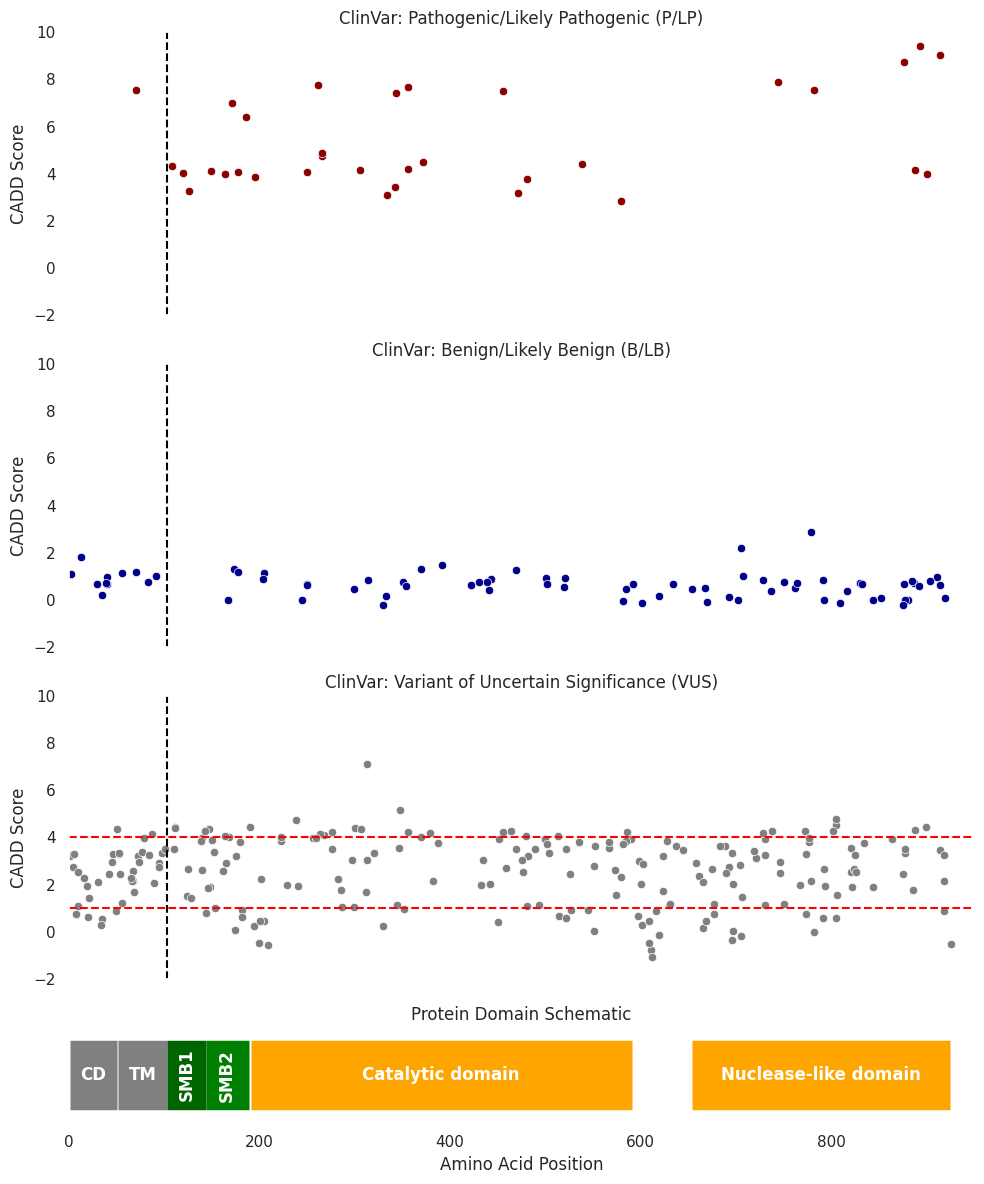

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample filtering
p_lp_df = score_df[score_df['clinical_annotation'] == 'P/LP']
b_lb_df = score_df[score_df['clinical_annotation'] == 'B/LB']
vus_df = score_df[score_df['clinical_annotation'] == 'VUS']

# Set up the figure and axes
fig, axes = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 3, 1]}, figsize=(10, 12))

# Plot top panel (P/LP)
sns.scatterplot(data=p_lp_df, x='aa_position', y='score', ax=axes[0], color=color_palette['P/LP'])
axes[0].set_ylim(-2,10)
axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].set_title('ClinVar: Pathogenic/Likely Pathogenic (P/LP)')
axes[0].set_ylabel('CADD Score')

# Plot second panel (B/LB)
sns.scatterplot(data=b_lb_df, x='aa_position', y='score', ax=axes[1], color=color_palette['B/LB'])
axes[1].set_ylim(-2,10)
axes[1].axvline(x=103, linestyle='--', color='black')
axes[1].set_title('ClinVar: Benign/Likely Benign (B/LB)')
axes[1].set_ylabel('CADD Score')

# Plot third panel (VUS)
sns.scatterplot(data=vus_df, x='aa_position', y='score', ax=axes[2], color=color_palette['VUS'])
axes[2].set_ylim(-2,10)
axes[2].axvline(x=103, linestyle='--', color='black')
axes[2].axhline(y=1, linestyle='--', color='red') ## putative CADD cutoffs
axes[2].axhline(y=4, linestyle='--', color='red') ## putative CADD cutoffs
axes[2].set_title('ClinVar: Variant of Uncertain Significance (VUS)')
axes[2].set_ylabel('CADD Score')

# Box schematic panel
axes[3].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[3].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[3].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[3].hlines(1, 144, 189, colors='green', linewidth=50)
axes[3].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[3].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[3].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[3].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[3].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[3].set_xlim(0, 950)
axes[3].set_yticks([])
axes[3].set_xlabel('Amino Acid Position')
axes[3].set_title('Protein Domain Schematic')
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
axes[3].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_aapos_clinvar.png')
plt.show()

#### All Variants Highlight P/LP

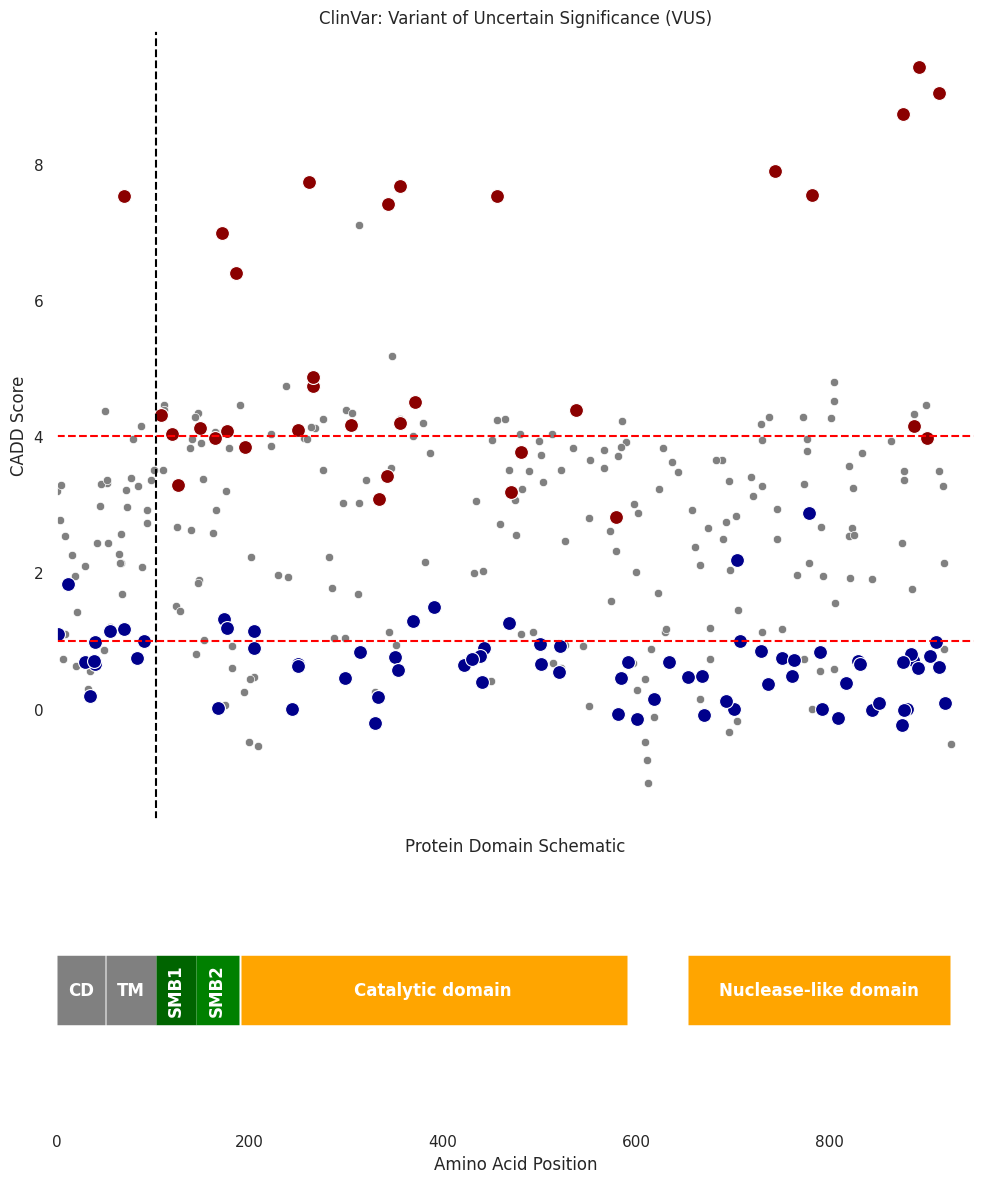

In [ ]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 12))

# Plot Variant Panel
# Sample filtering
p_lp_df = score_df[score_df['clinical_annotation'] == 'P/LP']
b_lb_df = score_df[score_df['clinical_annotation'] == 'B/LB']
rest_df = score_df[score_df['clinical_annotation'] != 'P/LP']


sns.scatterplot(data=rest_df, x='aa_position', y='score', ax=axes[0], color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position', y='score', ax=axes[0], color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='score', ax=axes[0], color=color_palette['B/LB'], s=100)
axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].axhline(y=1, linestyle='--', color='red') ## putative CADD cutoffs
axes[0].axhline(y=4, linestyle='--', color='red') ## putative CADD cutoffs
axes[0].set_title('ClinVar: Variant of Uncertain Significance (VUS)')
axes[0].set_ylabel('CADD Score')

# Box schematic panel
axes[1].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[1].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[1].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[1].hlines(1, 144, 189, colors='green', linewidth=50)
axes[1].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[1].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[1].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[1].set_xlim(0, 950)
axes[1].set_yticks([])
axes[1].set_xlabel('Amino Acid Position')
axes[1].set_title('Protein Domain Schematic')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

### Highlight Case Studies

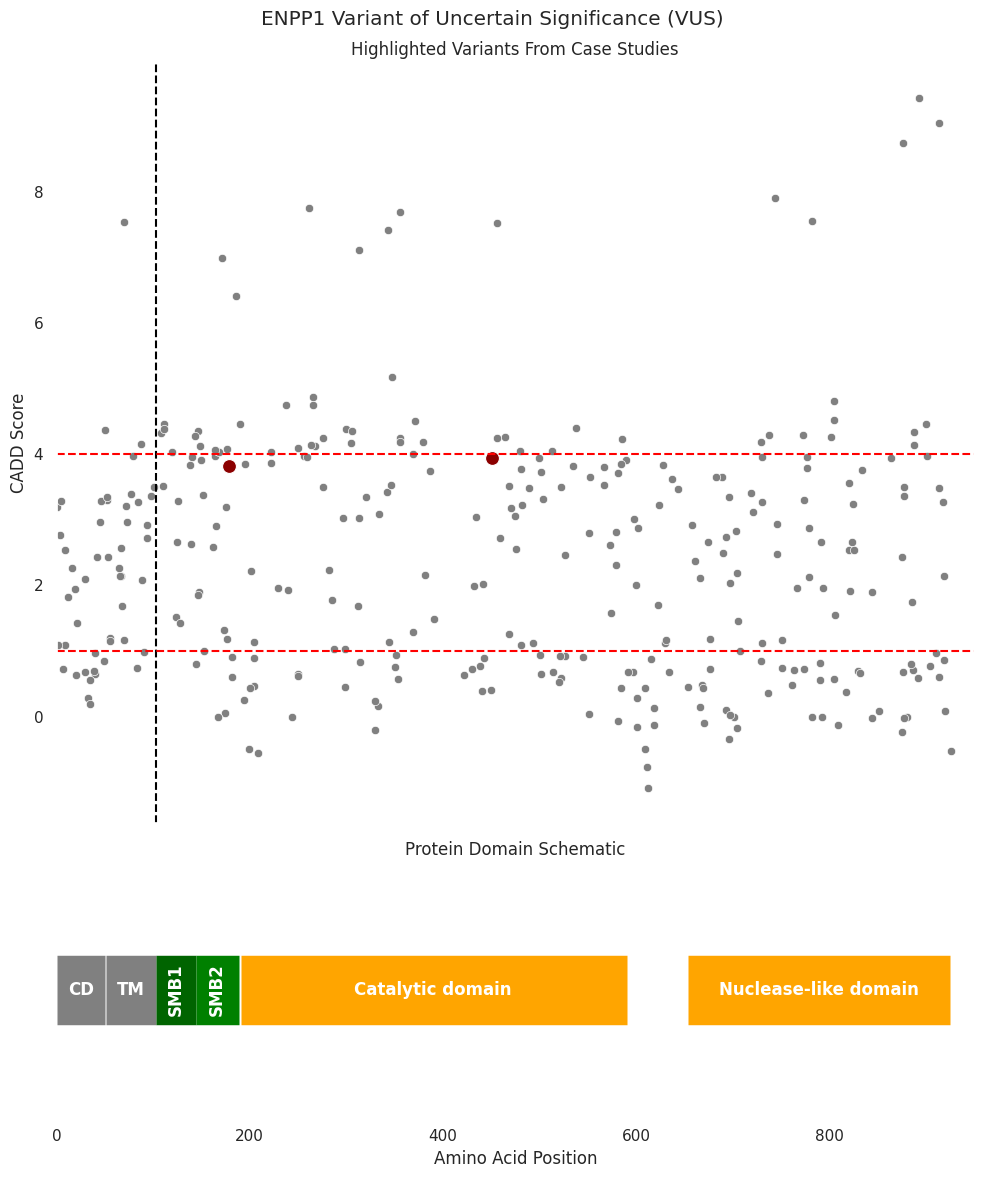

In [ ]:
# Plot third panel (VUS)
var_list=['p.Asn179Ser','p.Tyr451Cys']
vus_gray = score_df[~score_df['Protein Change'].isin(var_list)]
vus_highlight = score_df[score_df['Protein Change'].isin(var_list)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 12))

sns.scatterplot(data=vus_gray, x='aa_position', y='score', ax=axes[0], color=color_palette['VUS'])
sns.scatterplot(data=vus_highlight, x='aa_position', y='score', ax=axes[0], color=color_palette['P/LP'], s=100)

axes[0].axvline(x=103, linestyle='--', color='black')
axes[0].axhline(y=1, linestyle='--', color='red') ## putative CADD cutoffs
axes[0].axhline(y=4, linestyle='--', color='red') ## putative CADD cutoffs
fig.suptitle('ENPP1 Variant of Uncertain Significance (VUS)')
axes[0].set_title('Highlighted Variants From Case Studies')
axes[0].set_ylabel('CADD Score')

# Box schematic panel
axes[1].hlines(1, 1, 50, colors='gray', linewidth=50)
axes[1].hlines(1, 51, 103, colors='gray', linewidth=50)
axes[1].hlines(1, 103, 144, colors='darkgreen', linewidth=50)
axes[1].hlines(1, 144, 189, colors='green', linewidth=50)
axes[1].hlines(1, 191, 591, colors='orange', linewidth=50)
axes[1].hlines(1, 654, 925, colors='orange', linewidth=50)

# Add labels inside boxes
axes[1].text(25, 1, 'CD', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(77, 1, 'TM', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(123, 1, 'SMB1', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(166, 1, 'SMB2', color='white', ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1].text(390, 1, 'Catalytic domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
axes[1].text(789, 1, 'Nuclease-like domain', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

axes[1].set_xlim(0, 950)
axes[1].set_yticks([])
axes[1].set_xlabel('Amino Acid Position')
axes[1].set_title('Protein Domain Schematic')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

### Log Odds Cutoff Lines

<ipython-input-302-2d22fc72b170>:18: RuntimeWarning: divide by zero encountered in log
  ax.axhline(y=np.log(cutoff), linestyle='--', color=color_palette[funccode], label=funccode)
<ipython-input-302-2d22fc72b170>:21: RuntimeWarning: divide by zero encountered in log
  ax.text(x=400, y=np.log(cutoff), s=funccode, color=color_palette[funccode], fontsize=12, fontweight='bold')


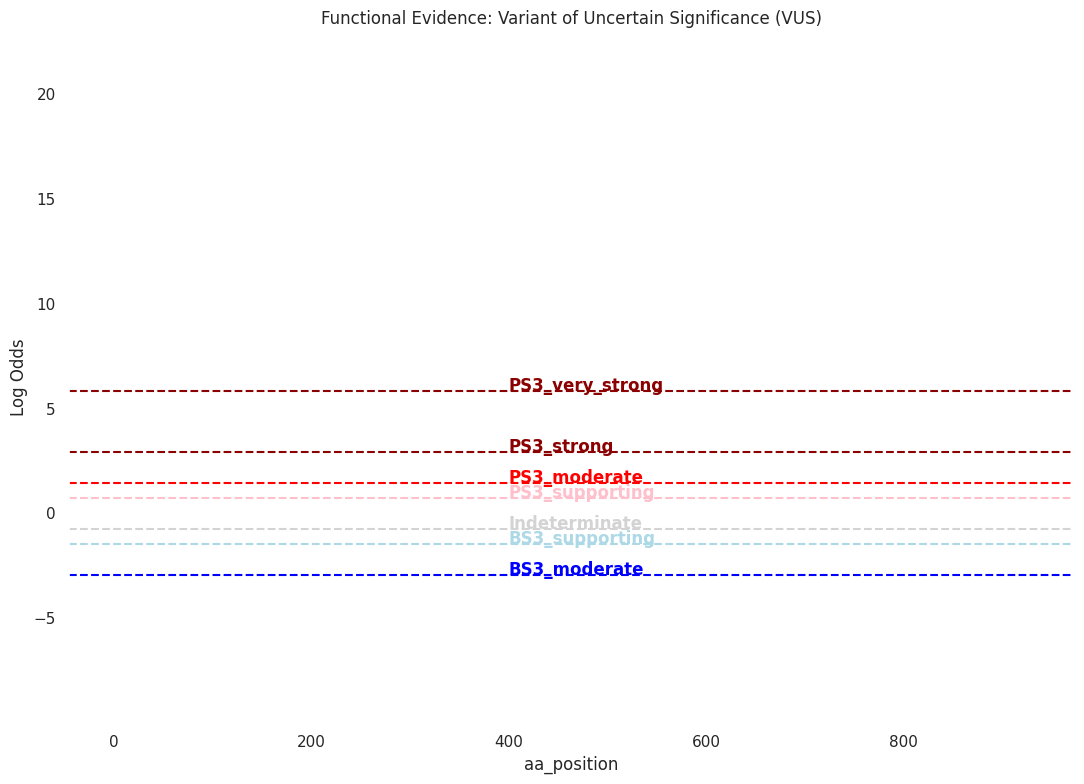

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
p_lp_df = score_df[score_df['func_code_short'] == 'PS3']
b_lb_df = score_df[score_df['func_code_short'] == 'BS3']
rest_df = score_df[score_df['func_code_short'] == 'Indeterminate']


sns.scatterplot(data=rest_df, x='aa_position', y='log_oddspath', hue='functional_evidence_code', ax=ax, palette=color_palette)
sns.scatterplot(data=p_lp_df, x='aa_position', y='log_oddspath', hue='functional_evidence_code', ax=ax, palette=color_palette, s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='log_oddspath', hue='functional_evidence_code', ax=ax, palette=color_palette, s=100)
ax.legend().remove()
# axes[0].axvline(x=103, linestyle='--', color='black')
cutoffs = [0, 0.053, 0.23, 0.48, 2.1, 4.3, 18.7, 350, float("inf")]
for cutoff, funccode in zip(cutoffs,functional_evidence_codes):
    ax.axhline(y=np.log(cutoff), linestyle='--', color=color_palette[funccode], label=funccode)

    # Add text annotation for the horizontal line
    ax.text(x=400, y=np.log(cutoff), s=funccode, color=color_palette[funccode], fontsize=12, fontweight='bold')


#
ax.set_title('Functional Evidence: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('Log Odds')

# Remove all scatter points
for collection in ax.collections:
    collection.remove()  # Removes plotted points

# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

<ipython-input-303-42fb7cb7dd20>:18: RuntimeWarning: divide by zero encountered in log
  ax.axhline(y=np.log(cutoff), linestyle='--', color=color_palette[funccode], label=funccode)
<ipython-input-303-42fb7cb7dd20>:21: RuntimeWarning: divide by zero encountered in log
  ax.text(x=400, y=np.log(cutoff), s=funccode, color=color_palette[funccode], fontsize=12, fontweight='bold')


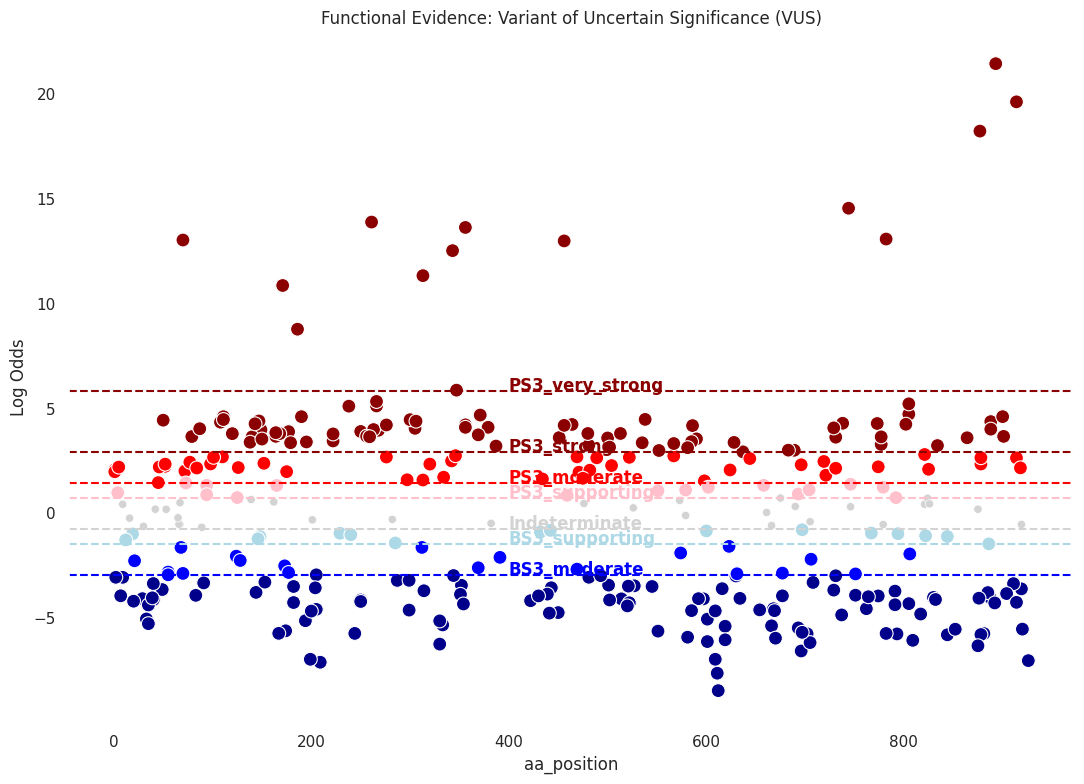

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
p_lp_df = score_df[score_df['func_code_short'] == 'PS3']
b_lb_df = score_df[score_df['func_code_short'] == 'BS3']
rest_df = score_df[score_df['func_code_short'] == 'Indeterminate']


sns.scatterplot(data=rest_df, x='aa_position', y='log_oddspath', hue='functional_evidence_code', ax=ax, palette=color_palette)
sns.scatterplot(data=p_lp_df, x='aa_position', y='log_oddspath', hue='functional_evidence_code', ax=ax, palette=color_palette, s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='log_oddspath', hue='functional_evidence_code', ax=ax, palette=color_palette, s=100)
ax.legend().remove()

# axes[0].axvline(x=103, linestyle='--', color='black')
cutoffs = [0, 0.053, 0.23, 0.48, 2.1, 4.3, 18.7, 350, float("inf")]
for cutoff, funccode in zip(cutoffs,functional_evidence_codes):
    ax.axhline(y=np.log(cutoff), linestyle='--', color=color_palette[funccode], label=funccode)

    # Add text annotation for the horizontal line
    ax.text(x=400, y=np.log(cutoff), s=funccode, color=color_palette[funccode], fontsize=12, fontweight='bold')


#
ax.set_title('Functional Evidence: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('Log Odds')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

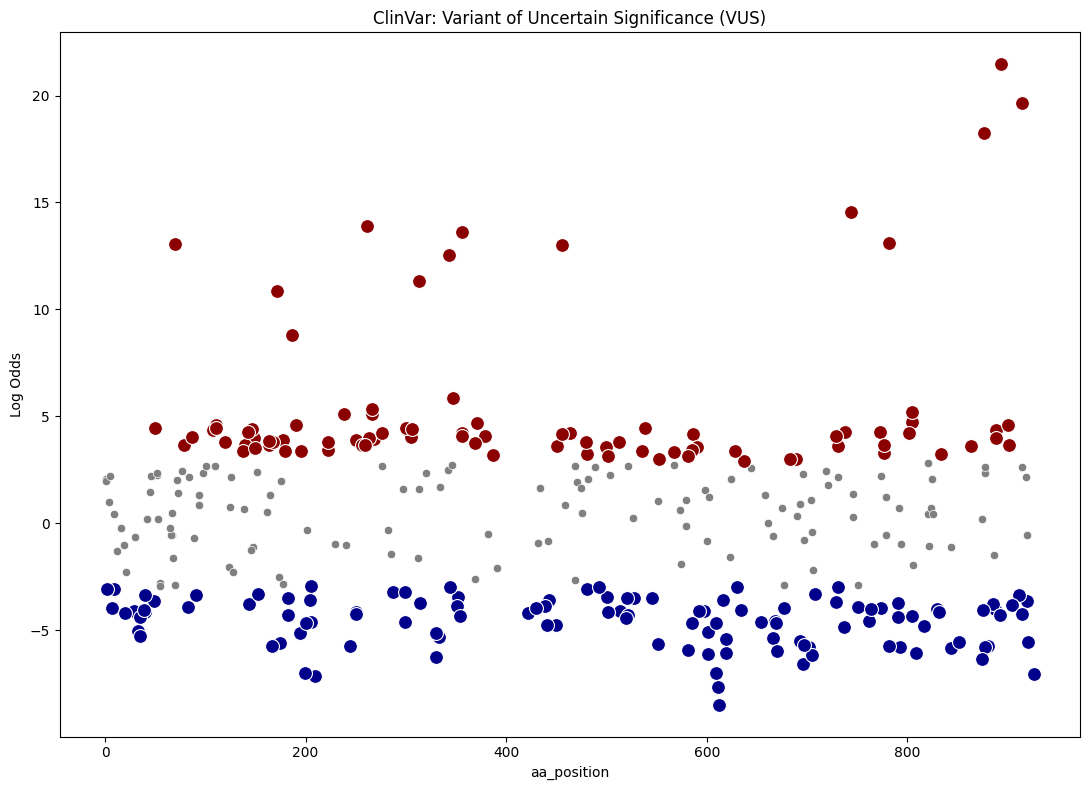

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
p_lp_df = score_df[score_df['func_code_short'] == 'PS3']
b_lb_df = score_df[score_df['func_code_short'] == 'BS3']
rest_df = score_df[score_df['func_code_short'] == 'Indeterminate']


sns.scatterplot(data=rest_df, x='aa_position', y='log_oddspath', ax=ax, color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position', y='log_oddspath', ax=ax, color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='log_oddspath', ax=ax, color=color_palette['B/LB'], s=100)
# axes[0].axvline(x=103, linestyle='--', color='black')
# axes[0].axhline(y=10, linestyle='--', color='red') ## putative CADD cutoffs
# axes[0].axhline(y=25, linestyle='--', color='red') ## putative CADD cutoffs
ax.set_title('ClinVar: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('Log Odds')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

In [ ]:
var_list = ['N179S','p.Asn179Ser','Y451C','p.Tyr451Cys']
score_df.query('`Protein Change`.isin(@var_list)')

,Unnamed: 0.1,Unnamed: 0,UID,Chrom,Position,Ref Base,Alt Base,Variant Note,Coding,Gene,...,clinical_annotation,score,oddspath,functional_evidence_code,auroc,num_pathogenic,num_benign,total_variants,func_code_short,log_oddspath
45,45,165,166,chr6,131851247,A,G,NaN,Yes,ENPP1,...,VUS,-8.793,2.456013,PS3_supporting,0.019048,21,10,31,PS3,0.898539
68,68,320,321,chr6,131869436,A,G,NaN,Yes,ENPP1,...,VUS,-12.266,9.763301,PS3_moderate,0.019048,21,10,31,PS3,2.278631


In [ ]:
score_df[['Position','Pos','Protein Change']]

,Position,Pos,Protein Change
0,131890410,131890410,p.Glu893Ter
1,131884939,131884939,p.Arg774Cys
2,131877005,131877005,p.Leu579Phe
3,131851228,131851228,p.Lys173Gln
4,131891554,131891554,NaN
...,...,...,...
468,131879896,131879896,p.His654Gln
469,131890360,131890360,p.Ser876Leu
470,131890487,131890487,p.Leu918Phe
471,131847795,131847795,p.Leu87Ser


In [ ]:
gnomad_df.head()

,VEP Annotation,Protein Consequence,ClinVar Clinical Significance,cadd,revel_max,spliceai_ds_max,pangolin_largest_ds,phylop,sift_max,polyphen_max,AA,aa_position,clinvar
37,missense_variant,p.Arg3His,NaN,22.6,NaN,0.0,0.00,4.740,0.02,0.353,His,3,VUS
39,missense_variant,p.Asp4Asn,VUS,23.0,NaN,0.0,0.00,7.260,0.00,0.188,Asn,4,VUS
41,missense_variant,p.Asp4Glu,NaN,21.5,NaN,0.0,0.00,-0.115,0.00,0.354,Glu,4,VUS
43,missense_variant,p.Gly5Cys,NaN,24.6,NaN,0.0,-0.01,2.510,0.00,0.774,Cys,5,VUS
45,missense_variant,p.Cys6Arg,NaN,20.1,NaN,0.0,0.00,-1.820,0.10,0.445,Arg,6,VUS


In [ ]:
score_df.head()

,Unnamed: 0.1,Unnamed: 0,UID,Chrom,Position,Ref Base,Alt Base,Variant Note,Coding,Gene,...,score,oddspath,functional_evidence_code,auroc,num_pathogenic,num_benign,total_variants,func_code_short,log_oddspath,aa_position
0,0,0,1,chr6,131890410,G,T,NaN,Yes,ENPP1,...,9.428650,2.082307e+09,PS3_very_strong,0.999795,33,148,181,PS3,21.456742,893.0
1,1,1,2,chr6,131884939,C,T,NaN,Yes,ENPP1,...,3.296722,9.169346e+00,Indeterminate,0.999795,33,148,181,Indeterminate,2.215866,774.0
2,2,2,3,chr6,131877005,G,C,NaN,Yes,ENPP1,...,2.820196,3.033861e+00,Indeterminate,0.999795,33,148,181,Indeterminate,1.109836,579.0
3,3,3,4,chr6,131851228,A,C,NaN,Yes,ENPP1,...,1.321265,8.130744e-02,Indeterminate,0.999795,33,148,181,Indeterminate,-2.509518,173.0
4,4,4,5,chr6,131891554,A,G,NaN,NaN,ENPP1,...,0.258418,6.102886e-03,BS3_strong,0.999795,33,148,181,BS3,-5.098994,NaN


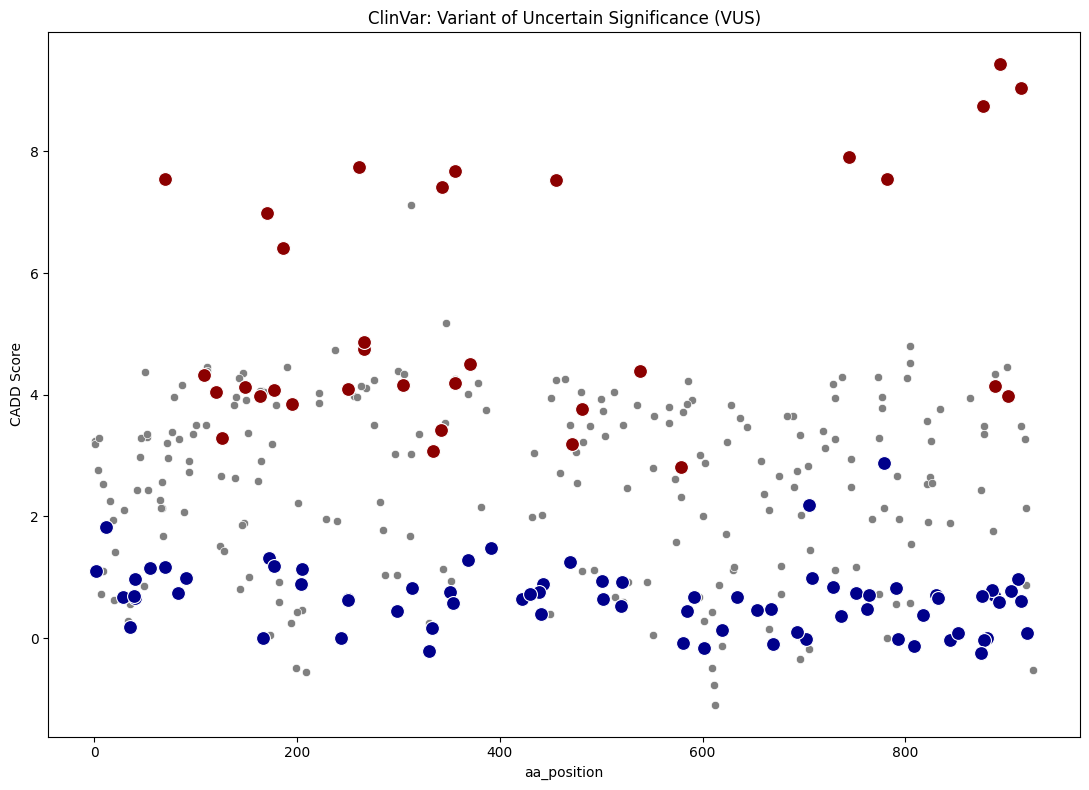

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
p_lp_df = score_df[score_df['clinical_annotation'] == 'P/LP']
b_lb_df = score_df[score_df['clinical_annotation'] == 'B/LB']
rest_df = score_df[score_df['clinical_annotation'] == 'VUS']


sns.scatterplot(data=rest_df, x='aa_position', y='score', ax=ax, color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position', y='score', ax=ax, color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='score', ax=ax, color=color_palette['B/LB'], s=100)
# axes[0].axvline(x=103, linestyle='--', color='black')
# axes[0].axhline(y=10, linestyle='--', color='red') ## putative CADD cutoffs
# axes[0].axhline(y=25, linestyle='--', color='red') ## putative CADD cutoffs
ax.set_title('ClinVar: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('CADD Score')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

### Add Cutoff Lines to Score Clinical Annotation

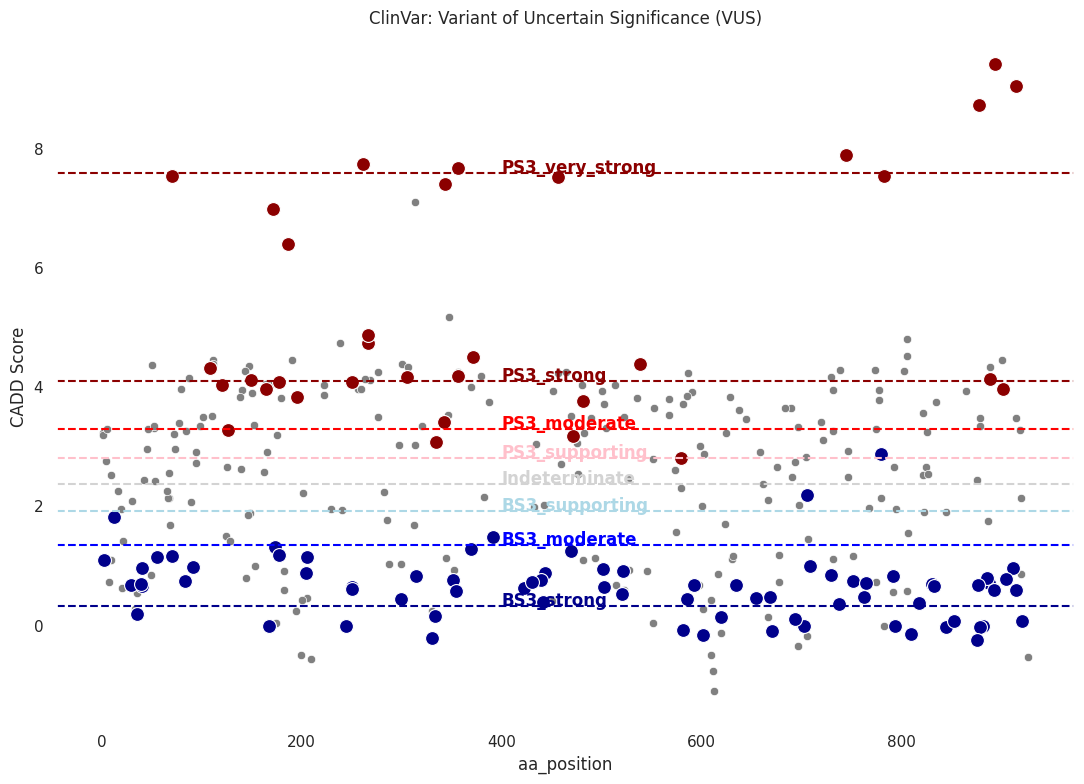

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
p_lp_df = score_df[score_df['clinical_annotation'] == 'P/LP']
b_lb_df = score_df[score_df['clinical_annotation'] == 'B/LB']
rest_df = score_df[score_df['clinical_annotation'] == 'VUS']


sns.scatterplot(data=rest_df, x='aa_position', y='score', ax=ax, color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position', y='score', ax=ax, color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='score', ax=ax, color=color_palette['B/LB'], s=100)

# axes[0].axvline(x=103, linestyle='--', color='black')
for funccode, cutoff in score_df.groupby('functional_evidence_code')['score'].mean().reindex(functional_evidence_codes).to_dict().items():
    ax.axhline(y=cutoff, linestyle='--', color=color_palette[funccode], label=funccode)

    # Add text annotation for the horizontal line
    ax.text(x=400, y=cutoff, s=funccode, color=color_palette[funccode], fontsize=12, fontweight='bold')


ax.set_title('ClinVar: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('CADD Score')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

### Add Cutoff Lines to Score Functional Annotation

In [ ]:
score_df.groupby('functional_evidence_code')['score'].mean()

,score
functional_evidence_code,
BS3_moderate,1.352430
BS3_strong,0.325985
BS3_supporting,1.914917
Indeterminate,2.377667
PS3_moderate,3.307010
PS3_strong,4.103293
PS3_supporting,2.819981
PS3_very_strong,7.590392


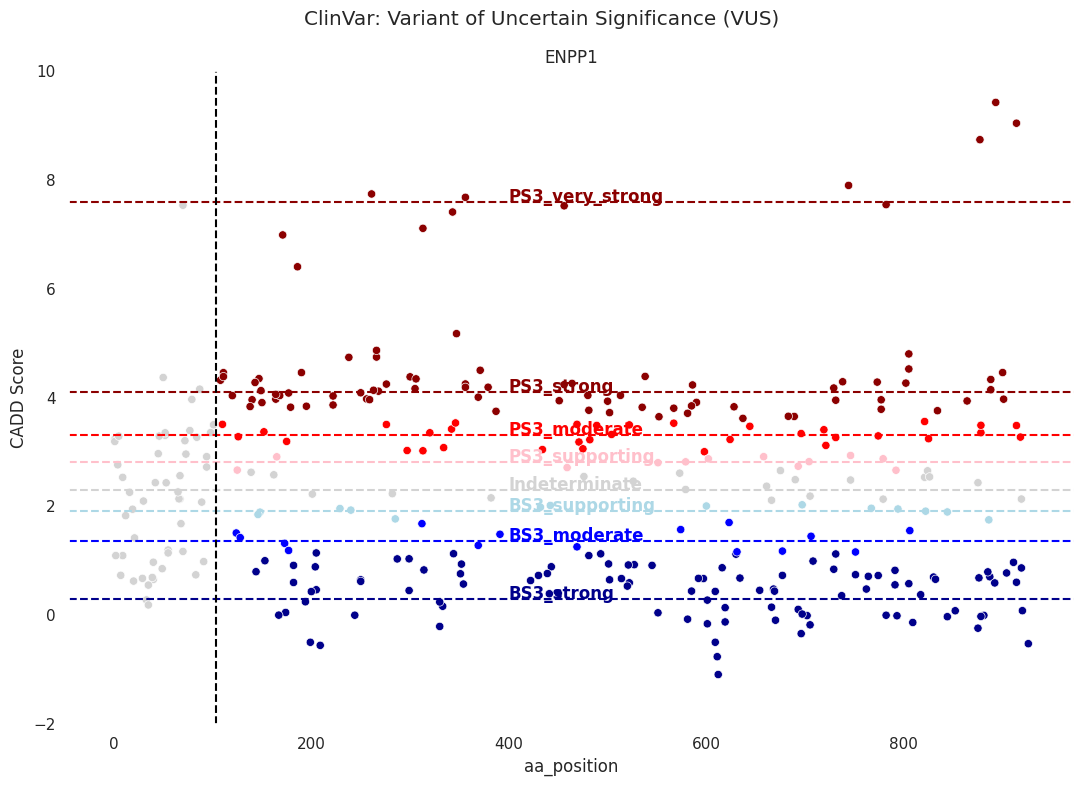

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
plot_df = score_df

# Change values in 'functional_evidence_code' where 'aa_position' is less than 103
plot_df.loc[plot_df['aa_position'] < 103, 'functional_evidence_code'] = 'Indeterminate'

sns.scatterplot(data=plot_df, x='aa_position', y='score', hue='functional_evidence_code', ax=ax, palette=color_palette)

# axes[0].axvline(x=103, linestyle='--', color='black')
for funccode, cutoff in score_df.groupby('functional_evidence_code')['score'].mean().reindex(functional_evidence_codes).to_dict().items():
    ax.axhline(y=cutoff, linestyle='--', color=color_palette[funccode], label=funccode)

    # Add text annotation for the horizontal line
    ax.text(x=400, y=cutoff, s=funccode, color=color_palette[funccode], fontsize=12, fontweight='bold')

ax.axvline(x=103, linestyle='--', color='black')
fig.suptitle('ClinVar: Variant of Uncertain Significance (VUS)')
ax.set_title('ENPP1')
ax.set_ylabel('CADD Score')
ax.set_ylim(-2,10)
ax.legend().remove()


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

### Plot Final Cutoffs

In [ ]:
plot_df.groupby('func_code_short')['score'].agg(['min','max'])

,min,max
func_code_short,,
BS3,-1.358422,1.704299
Indeterminate,0.188980,7.537703
PS3,3.006114,9.428650


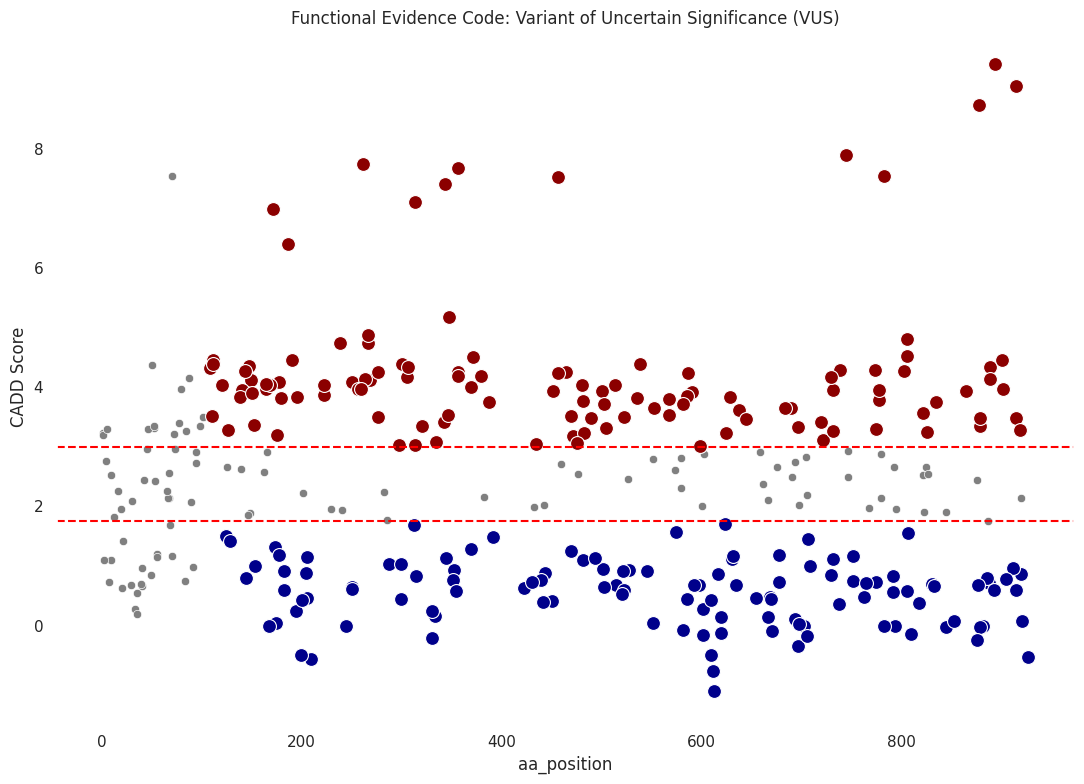

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
plot_df = score_df

# Change values in 'functional_evidence_code' where 'aa_position' is less than 103
plot_df.loc[plot_df['aa_position'] < 103, 'func_code_short'] = 'Indeterminate'

# Plot Variant Panel
# Sample filtering
p_lp_df = plot_df[plot_df['func_code_short'] == 'PS3']
b_lb_df = plot_df[plot_df['func_code_short'] == 'BS3']
rest_df = plot_df[plot_df['func_code_short'] == 'Indeterminate']


sns.scatterplot(data=rest_df, x='aa_position', y='score', ax=ax, color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position', y='score', ax=ax, color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position', y='score', ax=ax, color=color_palette['B/LB'], s=100)
# axes[0].axvline(x=103, linestyle='--', color='black')
ax.axhline(y=1.75, linestyle='--', color='red') ## putative CADD cutoffs
ax.axhline(y=3, linestyle='--', color='red') ## putative CADD cutoffs
ax.set_title('Functional Evidence Code: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('CADD Score')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

### Highligh Final Plot Case Studies

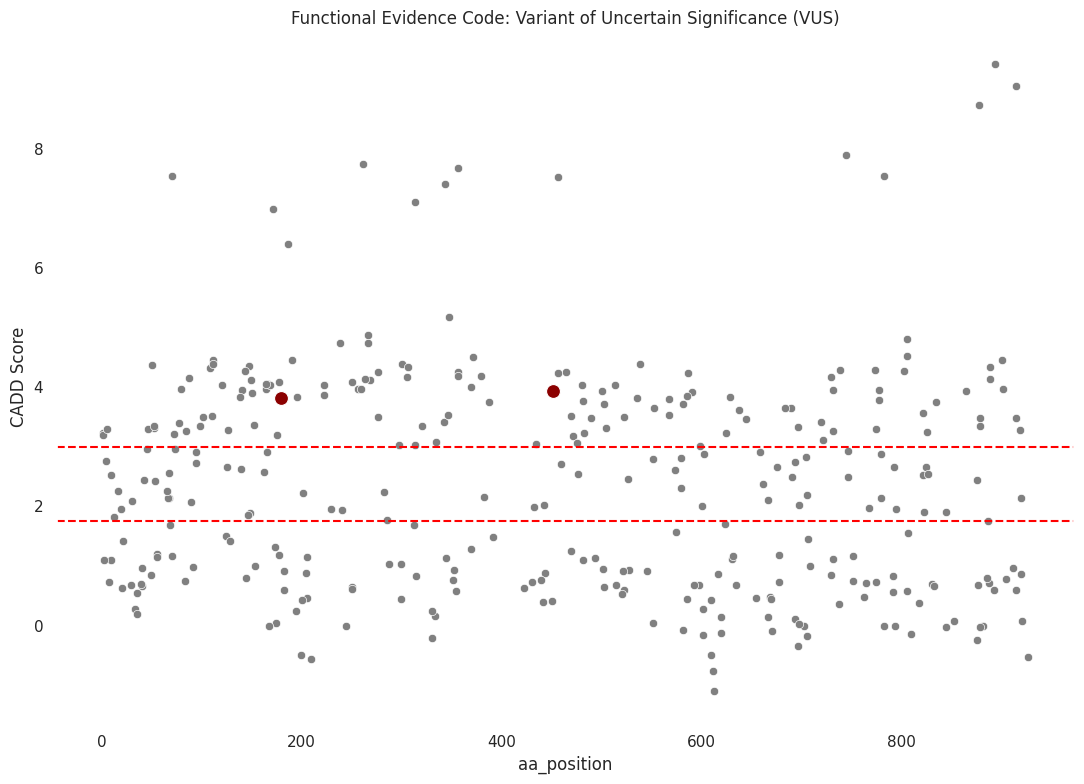

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
plot_df = score_df

# Change values in 'functional_evidence_code' where 'aa_position' is less than 103
plot_df.loc[plot_df['aa_position'] < 103, 'func_code_short'] = 'Indeterminate'

# Plot third panel (VUS)
var_list=['p.Asn179Ser','p.Tyr451Cys']
vus_gray = score_df[~score_df['Protein Change'].isin(var_list)]
vus_highlight = score_df[score_df['Protein Change'].isin(var_list)]


# Plot Variant Panel
sns.scatterplot(data=vus_gray, x='aa_position', y='score', ax=ax, color=color_palette['VUS'])
sns.scatterplot(data=vus_highlight, x='aa_position', y='score', ax=ax, color=color_palette['P/LP'], s=100)
# axes[0].axvline(x=103, linestyle='--', color='black')
ax.axhline(y=1.75, linestyle='--', color='red') ## putative CADD cutoffs
ax.axhline(y=3, linestyle='--', color='red') ## putative CADD cutoffs
ax.set_title('Functional Evidence Code: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('CADD Score')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

In [ ]:
pd.crosstab(score_df['functional_evidence_code'],score_df['clinical_annotation']).reindex(functional_evidence_codes).filter(['B/LB','VUS','P/LP'])

,B/LB,VUS,P/LP
functional_evidence_code,,,
BS3_strong,130,104,0
BS3_moderate,5,14,0
BS3_supporting,0,15,0
Indeterminate,12,60,1
PS3_supporting,1,10,1
PS3_moderate,0,30,4
PS3_strong,0,57,16
PS3_very_strong,0,2,11


In [ ]:
pd.crosstab(score_df['clinical_annotation'],score_df['functional_evidence_code']).filter(functional_evidence_codes)

,BS3_strong,BS3_moderate,BS3_supporting,Indeterminate,PS3_supporting,PS3_moderate,PS3_strong,PS3_very_strong
clinical_annotation,,,,,,,,
B/LB,130,5,0,12,1,0,0,0
P/LP,0,0,0,1,1,4,16,11
VUS,104,14,15,60,10,30,57,2


In [ ]:
print('Number of VUS: 292') # VUS
print('VUS reclassified: ' + str(1-(60/292)))
print('VUS not reclassified (moderate confidence): ' + str(1-(85/292)))

Number of VUS: 292
VUS reclassified: 0.7945205479452055
VUS not reclassified (moderate confidence): 0.7089041095890412


In [ ]:
tmpdf

,Chrom,Position,Ref Base,Alt Base
0,chr6,131890410,G,T
1,chr6,131884939,C,T
5,chr6,131861704,G,T
6,chr6,131864886,A,T
7,chr6,131860388,G,T
...,...,...,...,...
460,chr6,131864546,T,A
463,chr6,131872995,A,C
464,chr6,131875795,G,A
467,chr6,131877010,C,T


In [ ]:
code_list=['PS3_very_strong','PS3_strong','PS3_moderate']

tmpdf = score_df.query('functional_evidence_code.isin(@code_list)').filter(['Chrom',	'Position',	'Ref Base',	'Alt Base'])

out=[]
for i,row in tmpdf.iterrows():
  out.append('-'.join([row['Chrom'].replace('chr',''),str(row['Position']),row['Ref Base'],row['Alt Base']]))

pd.DataFrame(out).to_csv('ENPP1_cadd_reclassified_pathogenic.csv',index=False, header=None)

## Combining Datasets

In [ ]:
join_df = (
    gnomad_df.set_index('Protein Consequence')
    .join(score_df.set_index('Protein Change'), lsuffix='_gnomad', rsuffix='_score', how='left')
    .fillna('Indeterminate')
)

In [ ]:
join_df['func_code_short'].fillna('Indeterminate', inplace=True)

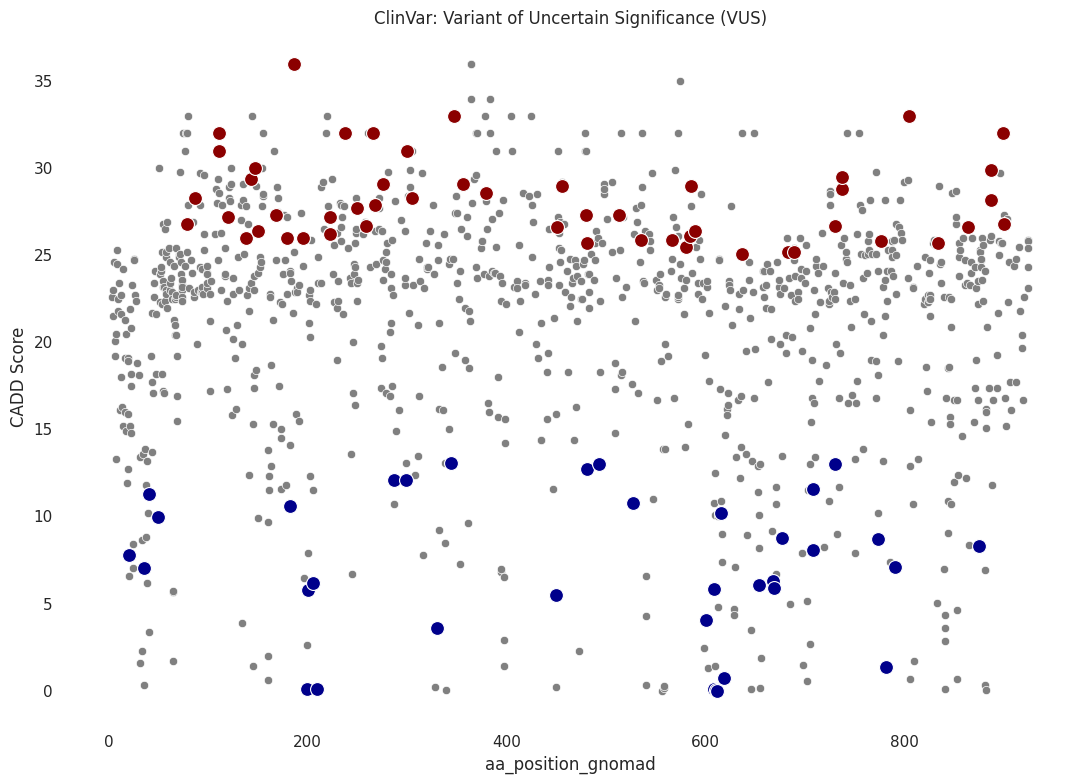

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(11, 8))

# Plot Variant Panel
# Sample filtering
p_lp_df = join_df[join_df['func_code_short'] == 'PS3']
b_lb_df = join_df[join_df['func_code_short'] == 'BS3']
rest_df = join_df[join_df['func_code_short'] == 'Indeterminate']


sns.scatterplot(data=rest_df, x='aa_position_gnomad', y='cadd', ax=ax, color=color_palette['VUS'])
sns.scatterplot(data=p_lp_df, x='aa_position_gnomad', y='cadd', ax=ax, color=color_palette['P/LP'], s=100)
sns.scatterplot(data=b_lb_df, x='aa_position_gnomad', y='cadd', ax=ax, color=color_palette['B/LB'], s=100)
# axes[0].axvline(x=103, linestyle='--', color='black')
# axes[0].axhline(y=10, linestyle='--', color='red') ## putative CADD cutoffs
# axes[0].axhline(y=25, linestyle='--', color='red') ## putative CADD cutoffs
ax.set_title('ClinVar: Variant of Uncertain Significance (VUS)')
ax.set_ylabel('CADD Score')


# Adjust layout
plt.tight_layout()
plt.savefig('ENPP1_cadd_by_highlight_variants.png')
plt.show()

In [ ]:
pd.crosstab(join_df['clinvar'],join_df['func_code_short'])

func_code_short,BS3,Indeterminate,PS3
clinvar,,,
B/LB,6,5,0
P/LP,0,3,9
VUS,30,976,43


In [ ]:
join_df

,VEP Annotation,ClinVar Clinical Significance,cadd,revel_max,spliceai_ds_max,pangolin_largest_ds,phylop,sift_max,polyphen_max,AA,...,score,oddspath,functional_evidence_code,auroc,num_pathogenic,num_benign,total_variants,func_code_short,log_oddspath,aa_position_score
Protein Consequence,,,,,,,,,,,,,,,,,,,,,
p.Arg3His,missense_variant,NaN,22.6,NaN,0.0,0.00,4.740,0.02,0.353,His,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Asp4Asn,missense_variant,VUS,23.0,NaN,0.0,0.00,7.260,0.00,0.188,Asn,...,2.765386,2.664301,Indeterminate,0.999795,33.0,148.0,181.0,Indeterminate,0.979942,4.0
p.Asp4Glu,missense_variant,NaN,21.5,NaN,0.0,0.00,-0.115,0.00,0.354,Glu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Gly5Cys,missense_variant,NaN,24.6,NaN,0.0,-0.01,2.510,0.00,0.774,Cys,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Cys6Arg,missense_variant,NaN,20.1,NaN,0.0,0.00,-1.820,0.10,0.445,Arg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p.Asp925Asn,missense_variant,NaN,24.3,NaN,0.0,-0.10,4.940,0.09,0.996,Asn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Asp925Tyr,missense_variant,NaN,25.9,NaN,0.0,-0.11,4.940,0.00,0.998,Tyr,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Asp925His,missense_variant,NaN,25.8,NaN,0.0,-0.12,4.940,0.00,0.998,His,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
